# `l2hmc-qcd`

This notebook contains a minimal working example for the 4D SU(3) Model

Uses `torch.complex128` by default

## Setup

In [1]:
# automatically detect and reload local changes to modules
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
!echo $CUDA_VISIBLE_DEVICES

2


In [2]:
devices = os.environ.get('CUDA_VISIBLE_DEVICES', None)
print(devices)
!getconf _NPROCESSORS_ONLN

2
256


In [3]:
from __future__ import absolute_import, print_function, annotations, division

import warnings
import logging

import torch
import numpy as np

warnings.filterwarnings('ignore')

os.environ['MASTER_PORT'] = '12345'
os.environ['OMP_NUM_THREADS'] = '256'

from l2hmc.utils.dist import (
    setup_torch
)

_ = setup_torch(
    precision='float64',
    backend='DDP',
    seed=1234,
)

from hydra.core.global_hydra import GlobalHydra

np.set_printoptions(threshold=5)
torch.set_printoptions(threshold=5, precision=5)

from rich.logging import RichHandler
from rich.style import Style
from rich.console import Console
from rich.logging import RichHandler
from l2hmc.utils.rich import get_console

console = get_console(width=120)
log = logging.getLogger()
handler = RichHandler(
    rich_tracebacks=True,
    tracebacks_show_locals=True,
    console=console,
    show_path=False,
    log_time_format='[%H:%m:%S]',
    enable_link_path=False,
)

log.handlers = [handler]

log.setLevel('INFO')

tlog = logging.getLogger('torch')
tlog.setLevel('ERROR')

wblog = logging.getLogger('wandb')
wblog.setLevel('CRITICAL')

--------------------------------------------------------------------------

  Local host:   thetagpu23
  Local device: mlx5_0
--------------------------------------------------------------------------


In [4]:
from l2hmc.experiment.pytorch.experiment import Experiment as ptExperiment

import l2hmc.group.su3.pytorch.group as gpt
ptsu3 = gpt.SU3()

import l2hmc
l2hmc.__file__

'/lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc/__init__.py'

## Specify defaults for building Experiment

In [5]:
GlobalHydra.instance().clear()

defaults_su3 = [
    'steps.nera=1',
    'steps.nepoch=10',
    'steps.test=50',
    # ------------------------------
    'conv=none',
    'network.activation_fn=tanh',
    'network.dropout_prob=0.0',
    'learning_rate.lr_init=0.0001',
    # ------------------------------
    'dynamics=su3',
    'dynamics.eps=0.01',
    'dynamics.nchains=2',
    'dynamics.nleapfrog=8',
    'dynamics.verbose=true',
    'dynamics.latvolume=[4, 4, 4, 8]',
    #'dynamics.use_split_xnets=false',
    #'dynamics.merge_directions=false',
    #'dynamics.use_separate_networks=false',
    # ------------------------------
    'net_weights.x.s=0.0',
    'net_weights.x.q=0.0',
    'net_weights.x.t=0.0',
    # ------------------------------
    'loss.charge_weight=0.0',
    'loss.plaq_weight=0.1',
    # ------------------------------
    'annealing_schedule.beta_init=1.0',
    'annealing_schedule.beta_final=1.0',
    #'net_weights.x.t=0.0',
    #'net_weights.x.q=0.0',
    # ------------------------------
]

In [6]:
import gc
import GPUtil

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
torch.clear_autocast_cache()
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  1% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


## Build Experiment

In [7]:
from l2hmc.configs import get_experiment

ptExpSU3 = get_experiment(
    overrides=[
        *defaults_su3,
        'framework=pytorch',
        'backend=DDP',
        'init_wandb=False',
        'init_aim=False',
        'learning_rate.clip_norm=10',
    ],
    build_networks=True,
)

[21:01:55] INFO     Caught MASTER_PORT:12345 from environment!

[21:01:56] INFO     Looking for checkpoints in:                                                                         
                     /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc/checkpoints/SU3/
                    4-4-4-4-8-3-3/nlf-8/xsplit-True/sepnets-True/merge-True/net-16-16-16_dp-0.0_bn-False/pytorch

           INFO     Loading model from: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2h
                    mc/checkpoints/SU3/4-4-4-4-8-3-3/nlf-8/xsplit-True/sepnets-True/merge-True/net-16-16-16_dp-0.0_bn-Fa
                    lse/pytorch/model-0-0-40-2023-01-26-210431.pth

[21:01:57] INFO     Loading checkpoint from: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/sr
                    c/l2hmc/checkpoints/SU3/4-4-4-4-8-3-3/nlf-8/xsplit-True/sepnets-True/merge-True/net-16-16-16_dp-0.0_
                    bn-False/pytorch/ckpt-0-0-40-2023-01-26-210431.tar

           WARNING  Restoring global step from ckpt! self._gstep: 40

           WARNING  Using `torch.optim.SGD` optimizer

           INFO     Caught MASTER_PORT:12345 from environment!

## Train

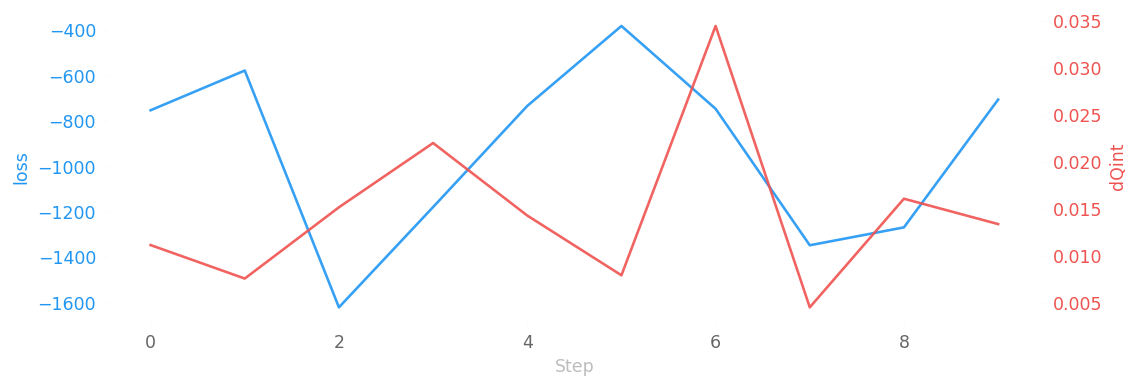

[21:01:01] INFO     [TRAINING] x.dtype: torch.complex128

           INFO     [TRAINING] self._dtype: torch.float64

────────────────────────────────── ERA: 0 / 0, BETA: 6.000 ──────────────────────────────────

Training:   0%|          | 0/10 [00:00<?, ?it/s]

[21:01:06] INFO     era=0   epoch=0   tstep=41  dt=1.4819 beta=6.0000 loss=-752.1487 dQsin=0.0004 dQint=0.0112          
                    energy=-10825.4438 logprob=-119248.8826 logdet=108423.4388 sldf=147455.5398 sldb=0.4584             
                    sld=108423.4388 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147455.9983 acc_mask=1.0000            
                    plaqs=0.5870 sinQ=0.0009 intQ=0.0276 lr=0.0001

[21:01:17] INFO     era=0   epoch=1   tstep=42  dt=1.2926 beta=6.0000 loss=-577.3142 dQsin=0.0003 dQint=0.0076          
                    energy=-10591.0145 logprob=-119014.4217 logdet=108423.4072 sldf=147455.4573 sldb=0.5138             
                    sld=108423.4072 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147455.9711 acc_mask=1.0000            
                    plaqs=0.5860 sinQ=0.0011 intQ=0.0334 lr=0.0001

[21:01:29] INFO     era=0   epoch=2   tstep=43  dt=1.3400 beta=6.0000 loss=-1619.8943 dQsin=0.0005 dQint=0.0152         
                    energy=-10883.3850 logprob=-119306.8426 logdet=108423.4576 sldf=147455.4410 sldb=0.7023             
                    sld=108423.4576 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147456.1433 acc_mask=1.0000            
                    plaqs=0.5877 sinQ=0.0009 intQ=0.0258 lr=0.0001

[21:01:41] INFO     era=0   epoch=3   tstep=44  dt=1.2705 beta=6.0000 loss=-1178.3362 dQsin=0.0008 dQint=0.0220         
                    energy=-10810.4668 logprob=-119233.7791 logdet=108423.3123 sldf=147455.2773 sldb=0.7025             
                    sld=108423.3123 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147455.9798 acc_mask=1.0000            
                    plaqs=0.5919 sinQ=0.0004 intQ=0.0106 lr=0.0001

[21:01:53] INFO     era=0   epoch=4   tstep=45  dt=1.2569 beta=6.0000 loss=-733.0897 dQsin=0.0005 dQint=0.0143          
                    energy=-10935.3829 logprob=-119358.7104 logdet=108423.3275 sldf=147455.2815 sldb=0.6102             
                    sld=108423.3275 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147455.8917 acc_mask=1.0000            
                    plaqs=0.5925 sinQ=0.0011 intQ=0.0327 lr=0.0001

[21:01:05] INFO     era=0   epoch=5   tstep=46  dt=1.2465 beta=6.0000 loss=-381.1109 dQsin=0.0003 dQint=0.0080          
                    energy=-10863.8966 logprob=-119287.3216 logdet=108423.4250 sldf=147455.4537 sldb=0.4997             
                    sld=108423.4250 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147455.9534 acc_mask=1.0000            
                    plaqs=0.5912 sinQ=0.0012 intQ=0.0342 lr=0.0001

[21:01:17] INFO     era=0   epoch=6   tstep=47  dt=1.2190 beta=6.0000 loss=-745.7219 dQsin=0.0012 dQint=0.0345          
                    energy=-10977.1791 logprob=-119400.5914 logdet=108423.4123 sldf=147455.3655 sldb=0.6921             
                    sld=108423.4123 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147456.0576 acc_mask=1.0000            
                    plaqs=0.5913 sinQ=0.0009 intQ=0.0263 lr=0.0001

[21:01:29] INFO     era=0   epoch=7   tstep=48  dt=1.2096 beta=6.0000 loss=-1346.5832 dQsin=0.0002 dQint=0.0045         
                    energy=-10915.6159 logprob=-119338.9450 logdet=108423.3292 sldf=147455.2888 sldb=0.6568             
                    sld=108423.3292 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147455.9456 acc_mask=1.0000            
                    plaqs=0.5921 sinQ=0.0015 intQ=0.0430 lr=0.0001

[21:01:41] INFO     era=0   epoch=8   tstep=49  dt=1.1805 beta=6.0000 loss=-1267.8662 dQsin=0.0006 dQint=0.0161         
                    energy=-10934.4123 logprob=-119357.7547 logdet=108423.3424 sldf=147455.4124 sldb=0.5151             
                    sld=108423.3424 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147455.9275 acc_mask=1.0000            
                    plaqs=0.5906 sinQ=0.0014 intQ=0.0406 lr=0.0001

[21:01:52] INFO     era=0   epoch=9   tstep=50  dt=1.1558 beta=6.0000 loss=-705.3554 dQsin=0.0005 dQint=0.0134          
                    energy=-10933.0368 logprob=-119356.4889 logdet=108423.4521 sldf=147455.6153 sldb=0.4651             
                    sld=108423.4521 xeps=0.0100 veps=0.0100 acc=1.0000 sumlogdet=147456.0804 acc_mask=1.0000            
                    plaqs=0.5903 sinQ=0.0008 intQ=0.0245 lr=0.0001

[21:01:53] INFO     Saving checkpoint to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l
                    2hmc/checkpoints/SU3/4-4-4-4-8-3-3/nlf-8/xsplit-True/sepnets-True/merge-True/net-16-16-16_dp-0.0_bn-
                    False/pytorch/ckpt-0-0-50-2023-01-26-212852.tar

           INFO     Saving modelfile to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2
                    hmc/checkpoints/SU3/4-4-4-4-8-3-3/nlf-8/xsplit-True/sepnets-True/merge-True/net-16-16-16_dp-0.0_bn-F
                    alse/pytorch/model-0-0-50-2023-01-26-212852.pth

           INFO     Saving took: 1.05925s

           INFO     Era 0 took: 172.274s

[21:01:55] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/train/plots/ridgeplots/svgs/energy_ridgeplot.svg

[21:01:56] INFO     Ridgeplot for energy took 2.311s

[21:01:57] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/train/plots/ridgeplots/svgs/logprob_ridgeplot.svg

[21:01:58] INFO     Ridgeplot for logprob took 1.905s

[21:01:59] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/train/plots/ridgeplots/svgs/logdet_ridgeplot.svg

[21:01:00] INFO     Ridgeplot for logdet took 2.000s

[21:01:02] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/train/plots/ridgeplots/svgs/sldf_ridgeplot.svg

[21:01:03] INFO     Ridgeplot for sldf took 2.643s

[21:01:04] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/train/plots/ridgeplots/svgs/sldb_ridgeplot.svg

[21:01:05] INFO     Ridgeplot for sldb took 2.050s

[21:01:06] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/train/plots/ridgeplots/svgs/sld_ridgeplot.svg

[21:01:07] INFO     Ridgeplot for sld took 2.024s

[21:01:17] INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hm
                    c/notebooks/outputs/2023-01-26-212555/pytorch/train/data/train_data.h5

           INFO     Done saving and analyzing data.

           INFO     Creating summaries for WandB, Aim

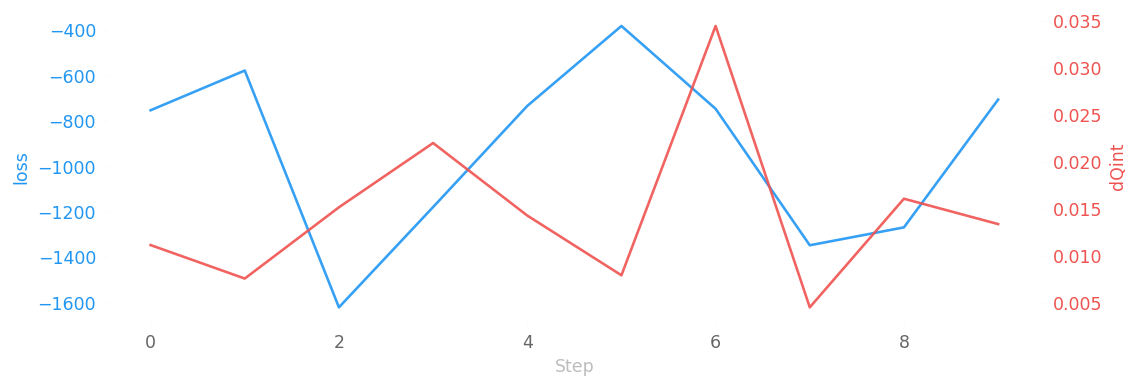

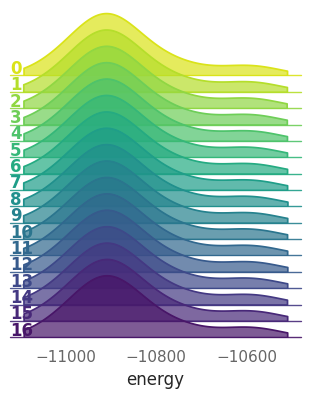

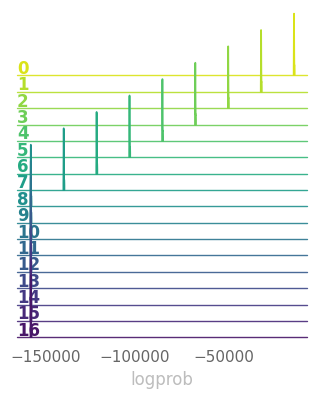

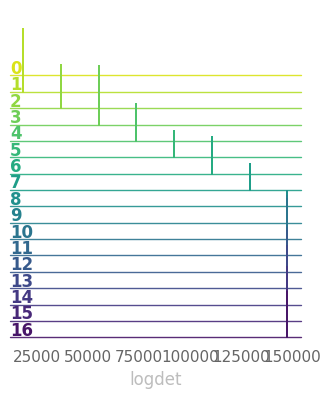

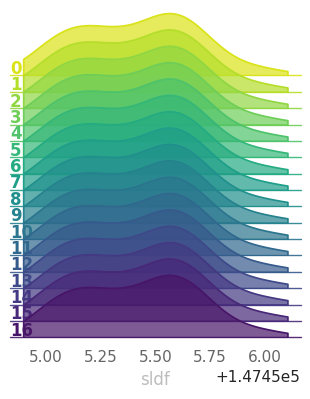

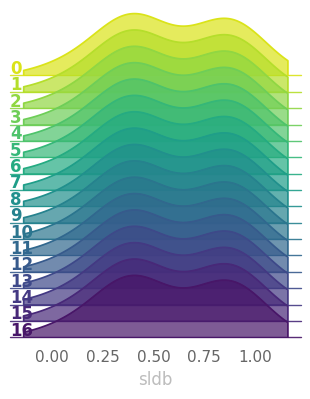

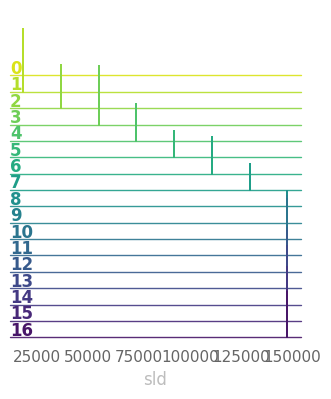

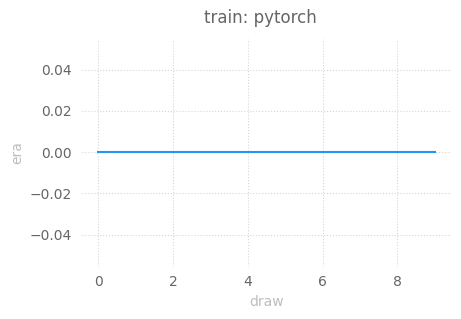

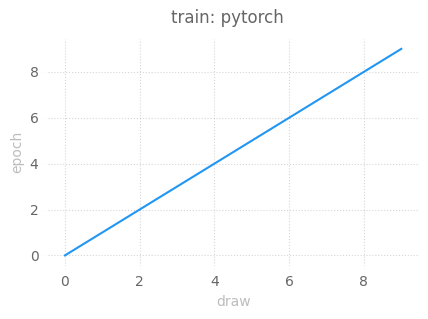

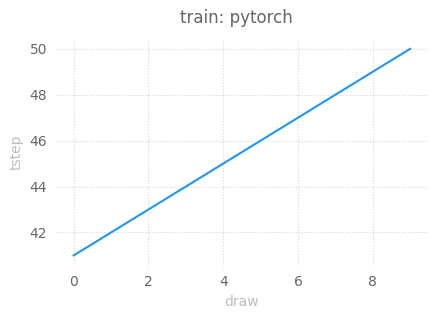

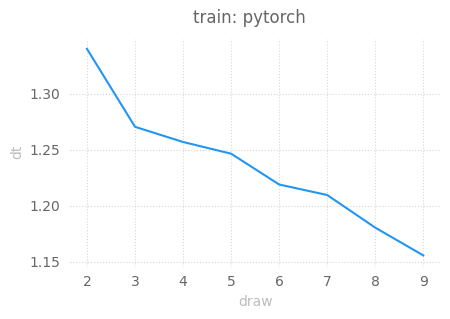

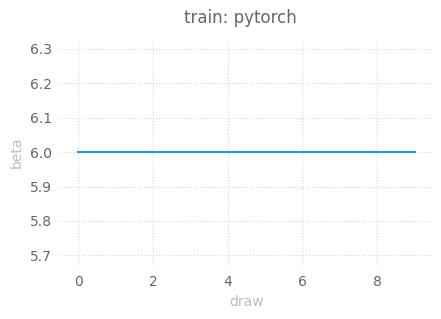

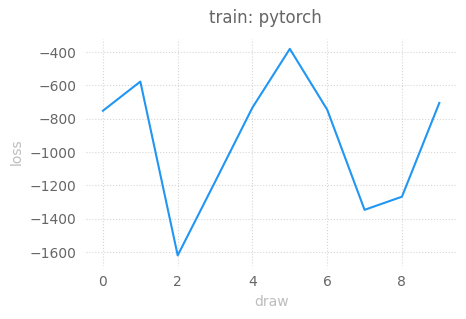

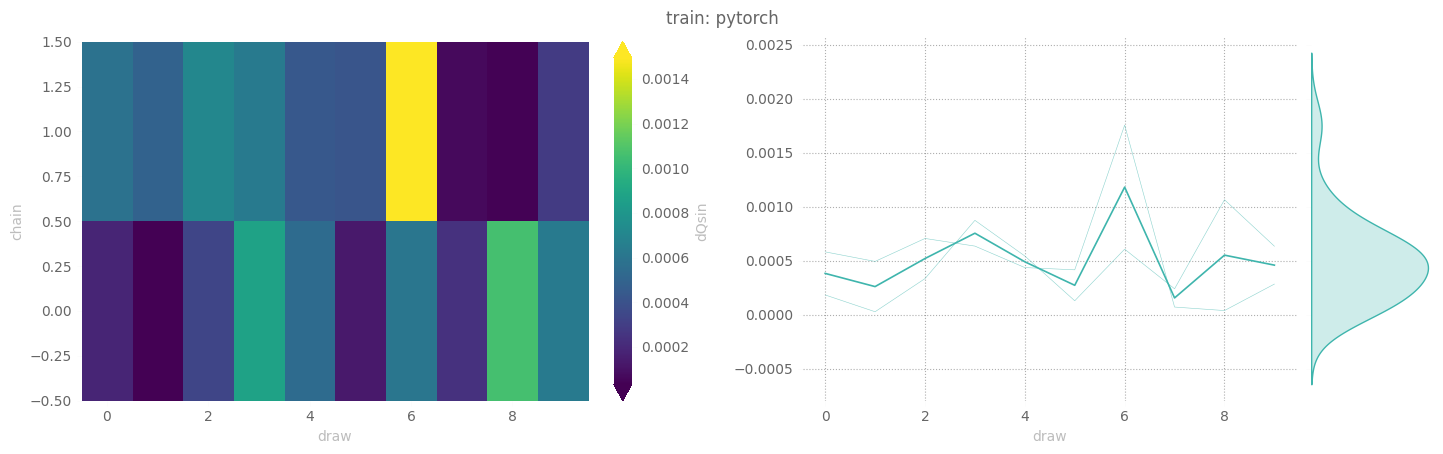

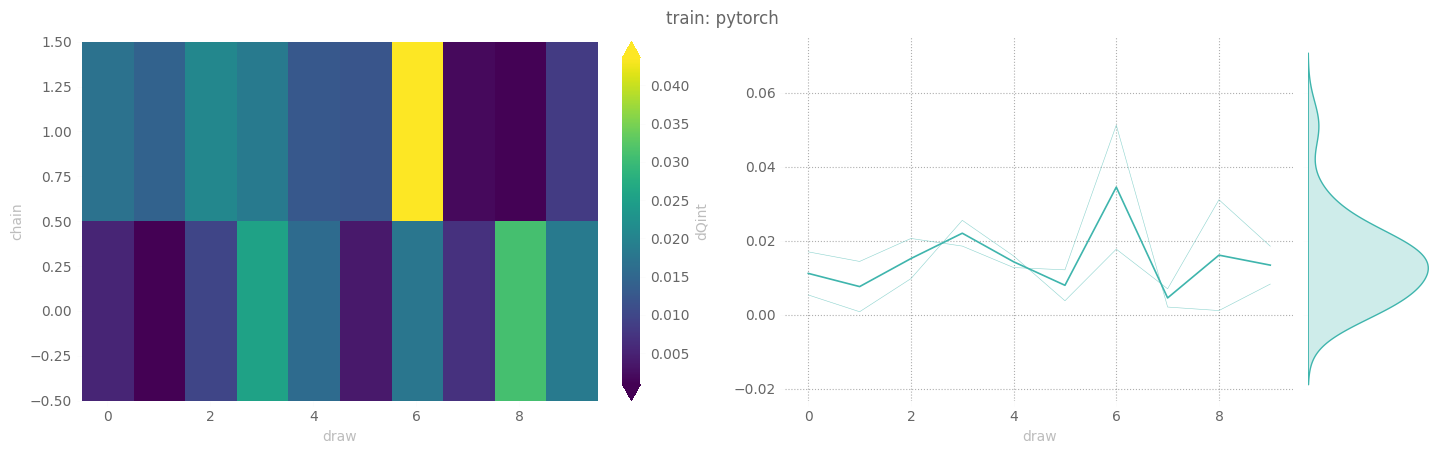

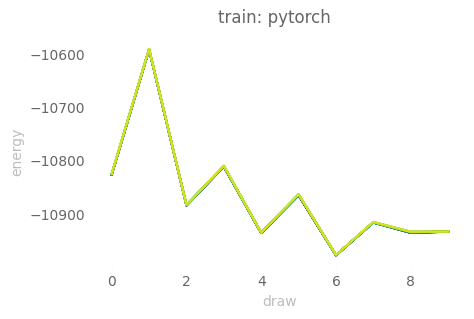

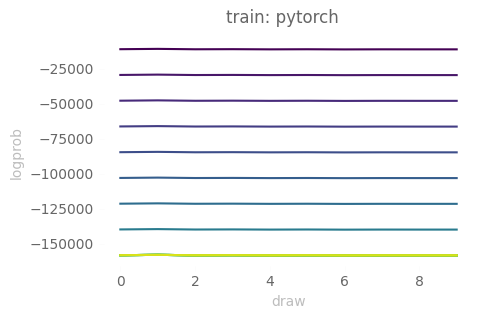

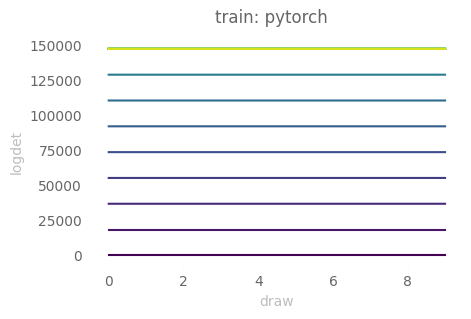

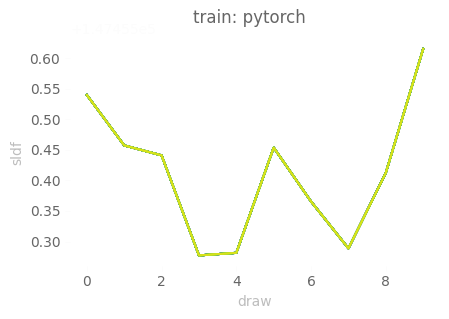

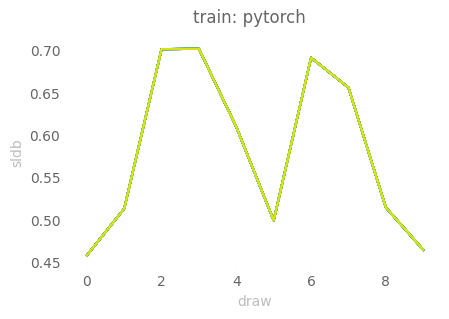

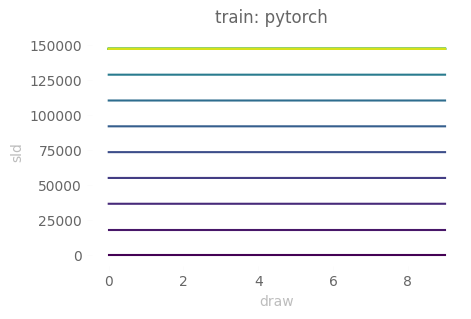

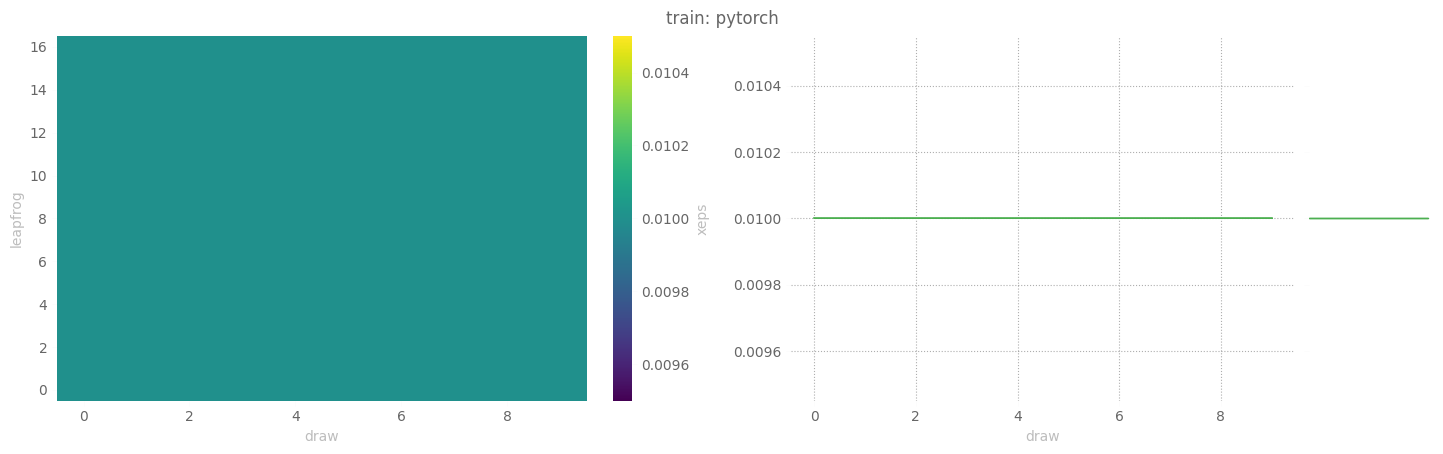

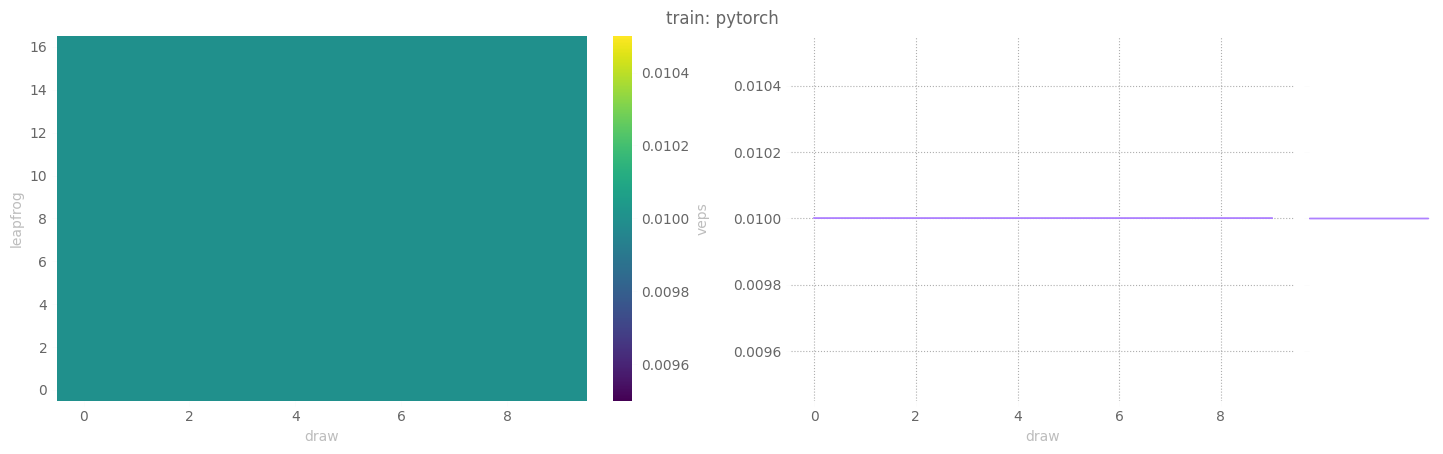

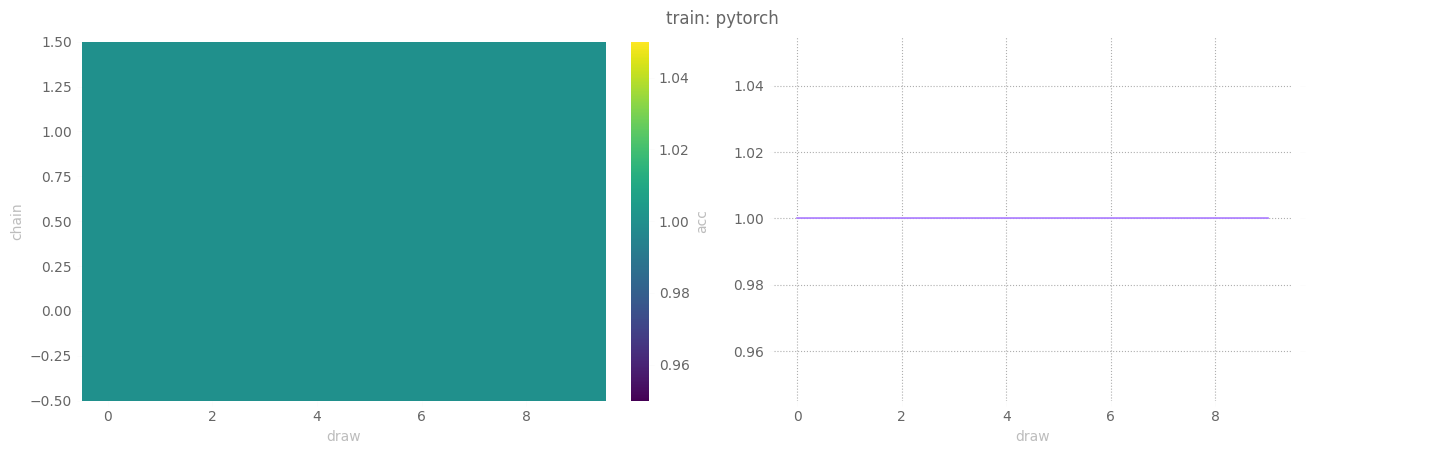

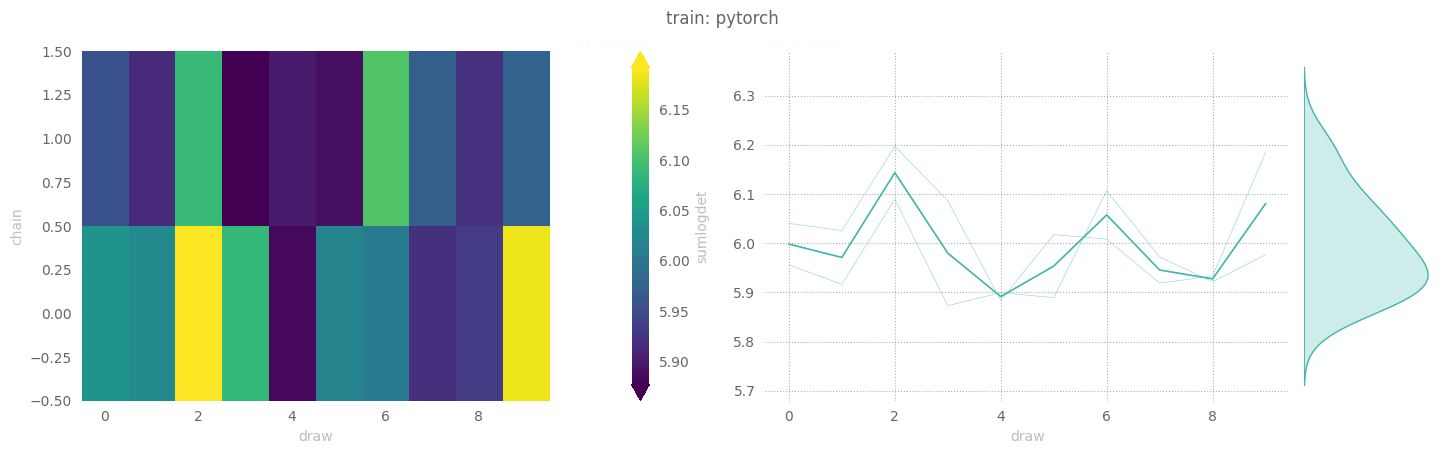

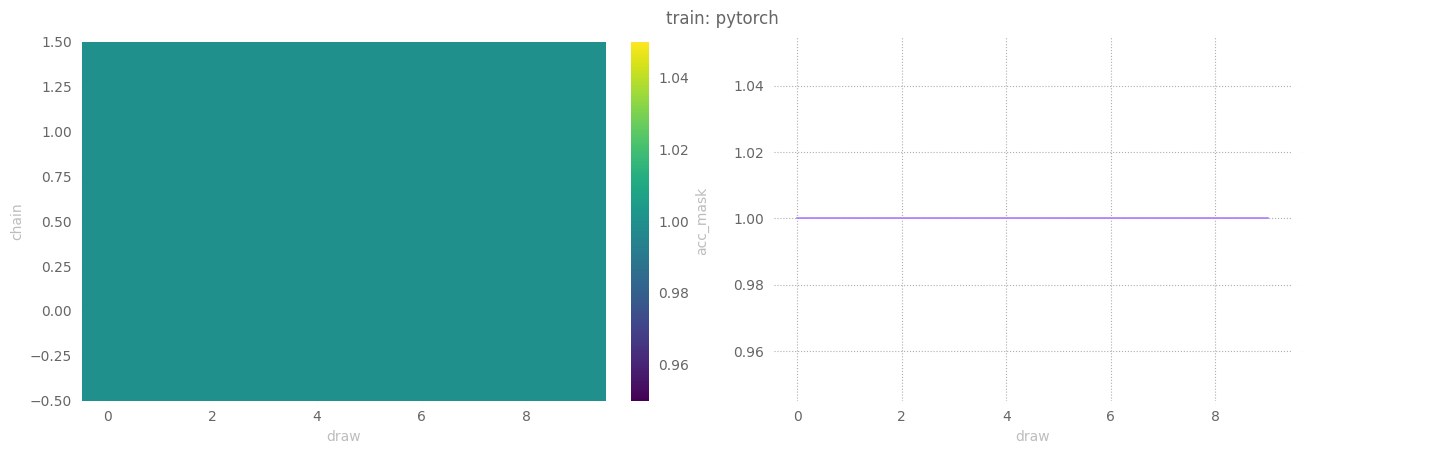

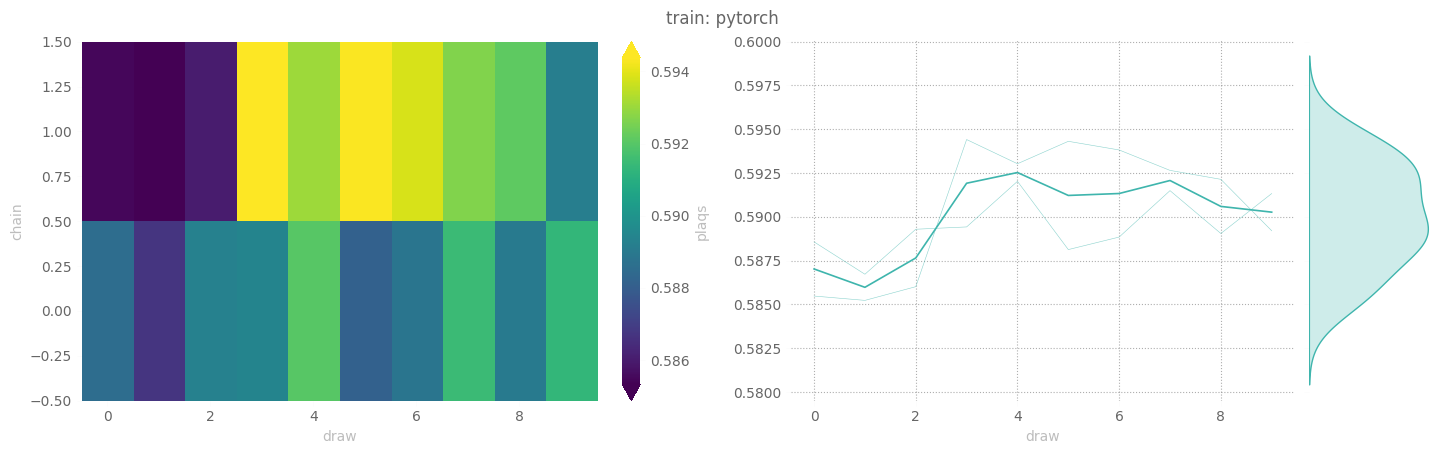

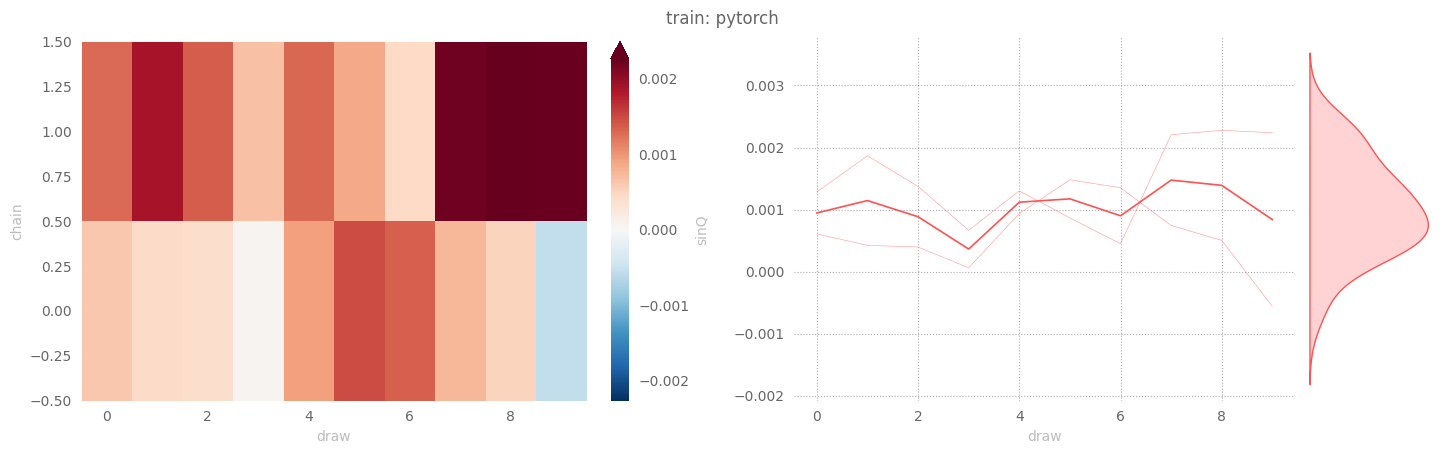

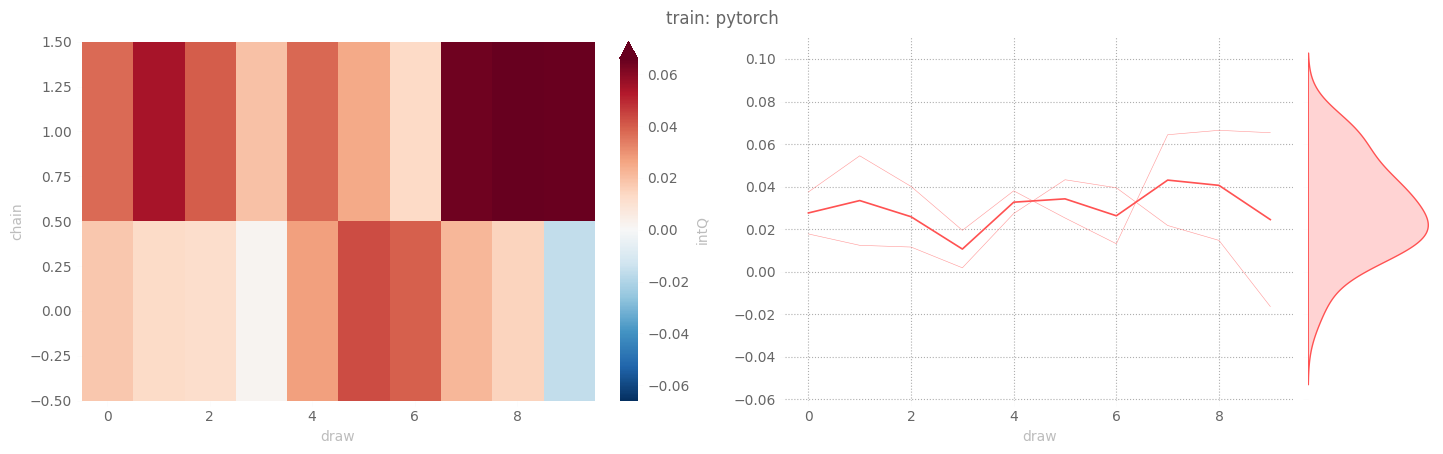

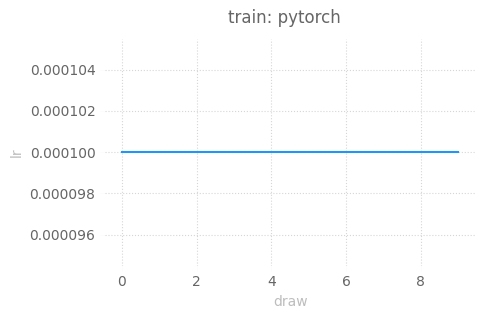

In [8]:
%matplotlib widget
from l2hmc.utils.plot_helpers import set_plot_style

set_plot_style()

train_out = ptExpSU3.train(beta=6.0)

## Evaluation

[21:01:05] WARNING  x.shape (original): torch.Size([2, 4, 4, 4, 4, 8, 3, 3])

           INFO     eps=None                                                                                            
                    beta=6.0                                                                                            
                    nlog=1                                                                                              
                    table=<rich.table.Table object at 0x7f06f55ae310>                                                   
                    nprint=1                                                                                            
                    eval_steps=10                                                                                       
                    nleapfrog=None

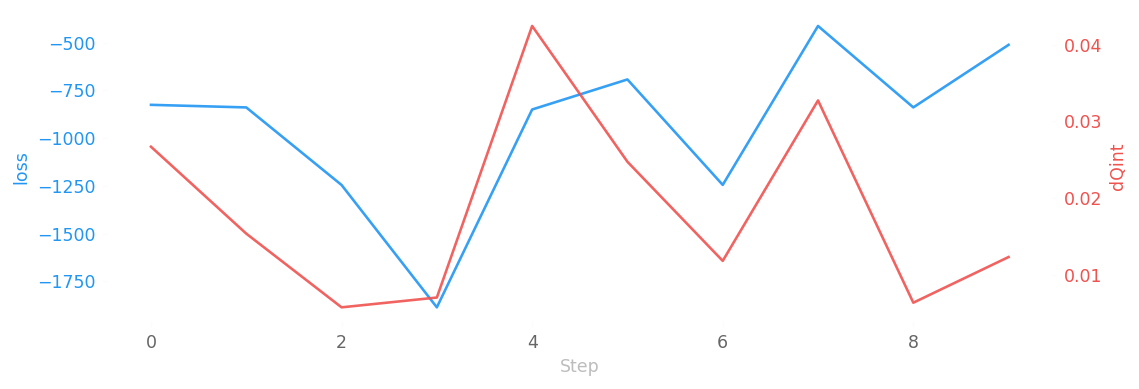

eval:   0%|          | 0/10 [00:00<?, ?it/s]

[21:01:03] INFO     estep=0   dt=0.5153 beta=6.0000 loss=-825.2705 dQsin=0.0009 dQint=0.0267 energy=-10733.1922         
                    logprob=-119156.4333 logdet=108423.2411 sldf=147455.2317 sldb=0.7380 sld=108423.2411 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147455.9697 acc_mask=1.0000 plaqs=0.5893 sinQ=-0.0002 intQ=-0.0059

[21:01:04] INFO     estep=1   dt=0.7573 beta=6.0000 loss=-838.8757 dQsin=0.0005 dQint=0.0153 energy=-10873.1351         
                    logprob=-119296.4221 logdet=108423.2870 sldf=147455.3249 sldb=0.6446 sld=108423.2870 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147455.9696 acc_mask=1.0000 plaqs=0.5878 sinQ=-0.0011 intQ=-0.0325

[21:01:05] INFO     estep=2   dt=0.5318 beta=6.0000 loss=-1245.5091 dQsin=0.0002 dQint=0.0057 energy=-10831.3942        
                    logprob=-119254.7005 logdet=108423.3063 sldf=147455.3124 sldb=0.6869 sld=108423.3063 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147455.9993 acc_mask=1.0000 plaqs=0.5881 sinQ=-0.0016 intQ=-0.0479

[21:01:06] INFO     estep=3   dt=0.5299 beta=6.0000 loss=-1886.9748 dQsin=0.0002 dQint=0.0070 energy=-11014.2064        
                    logprob=-119437.5022 logdet=108423.2958 sldf=147455.3279 sldb=0.6240 sld=108423.2958 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147455.9519 acc_mask=1.0000 plaqs=0.5918 sinQ=-0.0014 intQ=-0.0422

[21:01:07] INFO     estep=4   dt=0.5328 beta=6.0000 loss=-849.7470 dQsin=0.0015 dQint=0.0424 energy=-10919.8366         
                    logprob=-119343.1540 logdet=108423.3174 sldf=147455.3070 sldb=0.7341 sld=108423.3174 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147456.0411 acc_mask=1.0000 plaqs=0.5940 sinQ=-0.0016 intQ=-0.0470

[21:01:08] INFO     estep=5   dt=0.5397 beta=6.0000 loss=-692.2120 dQsin=0.0008 dQint=0.0247 energy=-10932.9766         
                    logprob=-119356.2359 logdet=108423.2592 sldf=147455.2669 sldb=0.6208 sld=108423.2592 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147455.8877 acc_mask=1.0000 plaqs=0.5947 sinQ=-0.0002 intQ=-0.0046

           INFO     estep=6   dt=0.5375 beta=6.0000 loss=-1245.0390 dQsin=0.0004 dQint=0.0118 energy=-10933.2885        
                    logprob=-119356.6365 logdet=108423.3480 sldf=147455.3951 sldb=0.5127 sld=108423.3480 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147455.9078 acc_mask=1.0000 plaqs=0.5944 sinQ=0.0007 intQ=0.0202

[21:01:09] INFO     estep=7   dt=0.5321 beta=6.0000 loss=-411.9079 dQsin=0.0011 dQint=0.0327 energy=-10911.0666         
                    logprob=-119334.5509 logdet=108423.4843 sldf=147455.5888 sldb=0.4718 sld=108423.4843 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147456.0605 acc_mask=1.0000 plaqs=0.5936 sinQ=0.0011 intQ=0.0320

[21:01:10] INFO     estep=8   dt=0.5325 beta=6.0000 loss=-838.7317 dQsin=0.0002 dQint=0.0063 energy=-10904.5754         
                    logprob=-119328.0299 logdet=108423.4545 sldf=147455.5539 sldb=0.4689 sld=108423.4545 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147456.0228 acc_mask=1.0000 plaqs=0.5914 sinQ=-0.0000 intQ=-0.0008

[21:01:11] INFO     estep=9   dt=1.0196 beta=6.0000 loss=-510.6867 dQsin=0.0004 dQint=0.0123 energy=-10866.5853         
                    logprob=-119290.0200 logdet=108423.4347 sldf=147455.4617 sldb=0.6201 sld=108423.4347 xeps=0.0100    
                    veps=0.0100 acc=1.0000 sumlogdet=147456.0818 acc_mask=1.0000 plaqs=0.5937 sinQ=0.0000 intQ=0.0013

[21:01:13] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/eval/plots/ridgeplots/svgs/energy_ridgeplot.svg

[21:01:14] INFO     Ridgeplot for energy took 2.083s

[21:01:15] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/eval/plots/ridgeplots/svgs/logprob_ridgeplot.svg

[21:01:16] INFO     Ridgeplot for logprob took 1.995s

[21:01:17] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/eval/plots/ridgeplots/svgs/logdet_ridgeplot.svg

[21:01:18] INFO     Ridgeplot for logdet took 2.097s

[21:01:19] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/eval/plots/ridgeplots/svgs/sldf_ridgeplot.svg

[21:01:20] INFO     Ridgeplot for sldf took 2.144s

[21:01:21] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/eval/plots/ridgeplots/svgs/sldb_ridgeplot.svg

[21:01:22] INFO     Ridgeplot for sldb took 2.140s

[21:01:24] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/eval/plots/ridgeplots/svgs/sld_ridgeplot.svg

[21:01:25] INFO     Ridgeplot for sld took 2.636s

[21:01:35] INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hm
                    c/notebooks/outputs/2023-01-26-212555/pytorch/eval/data/eval_data.h5

           INFO     Done saving and analyzing data.

           INFO     Creating summaries for WandB, Aim

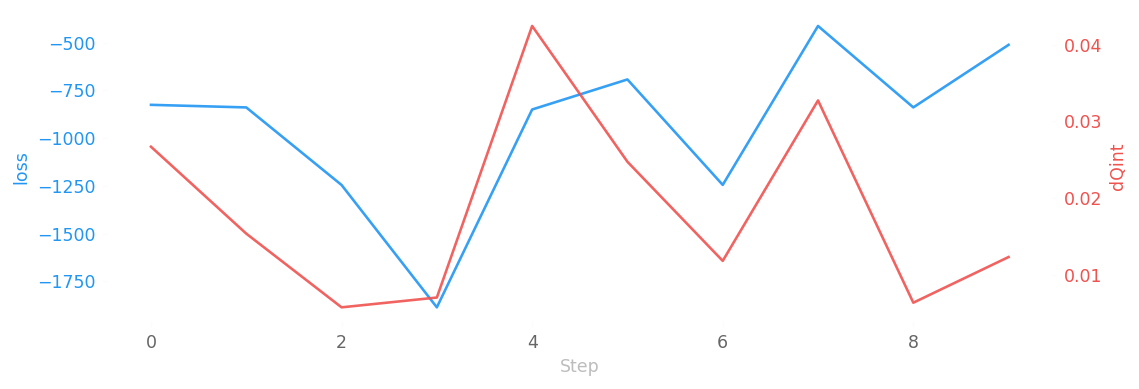

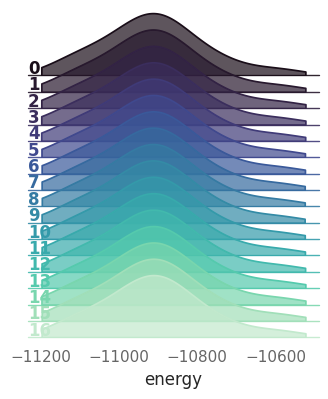

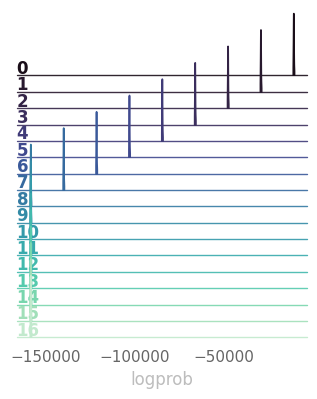

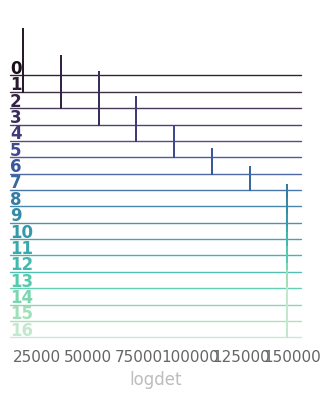

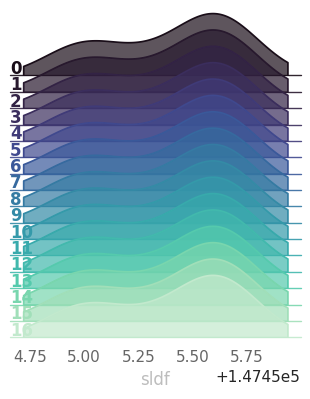

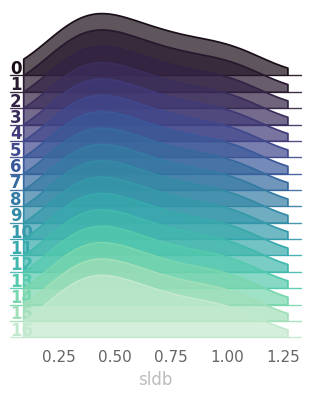

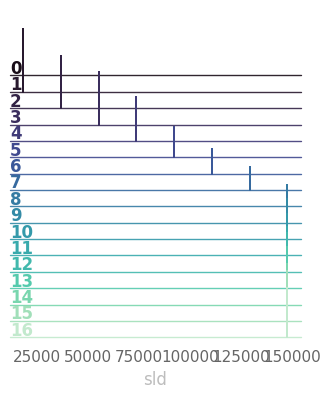

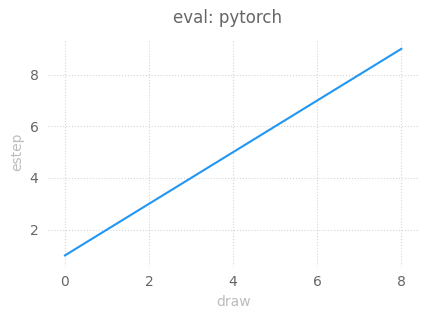

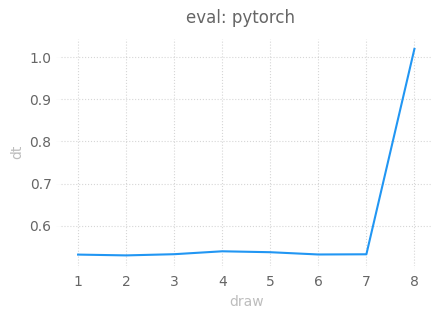

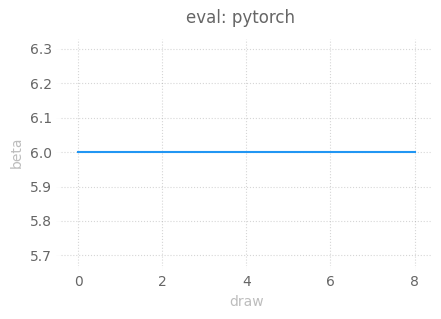

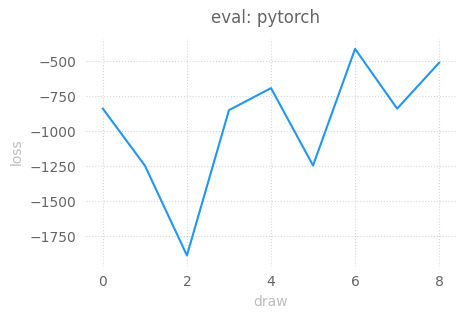

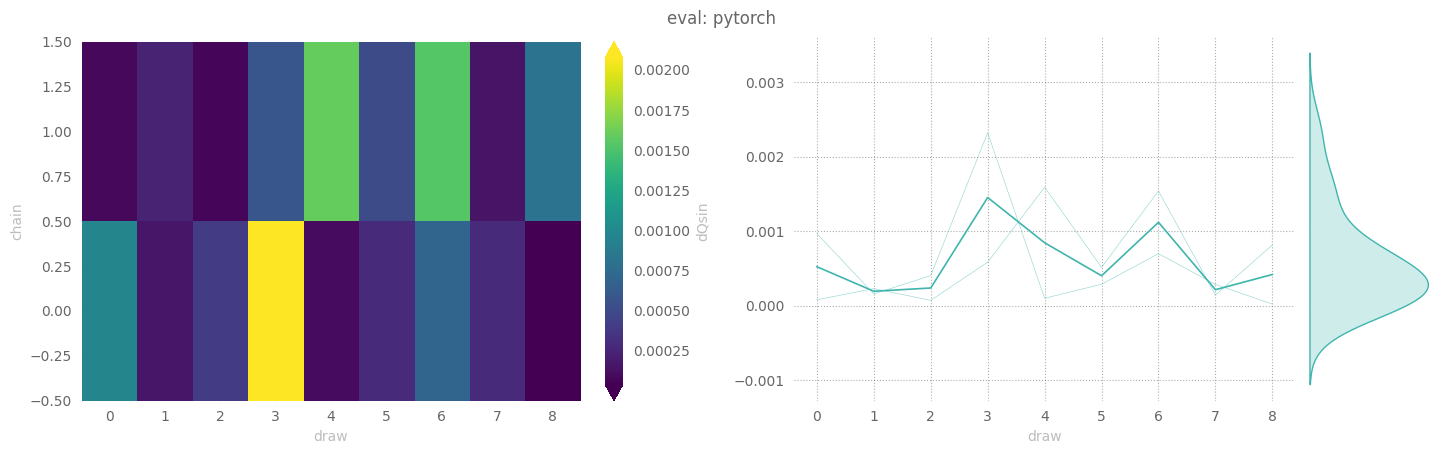

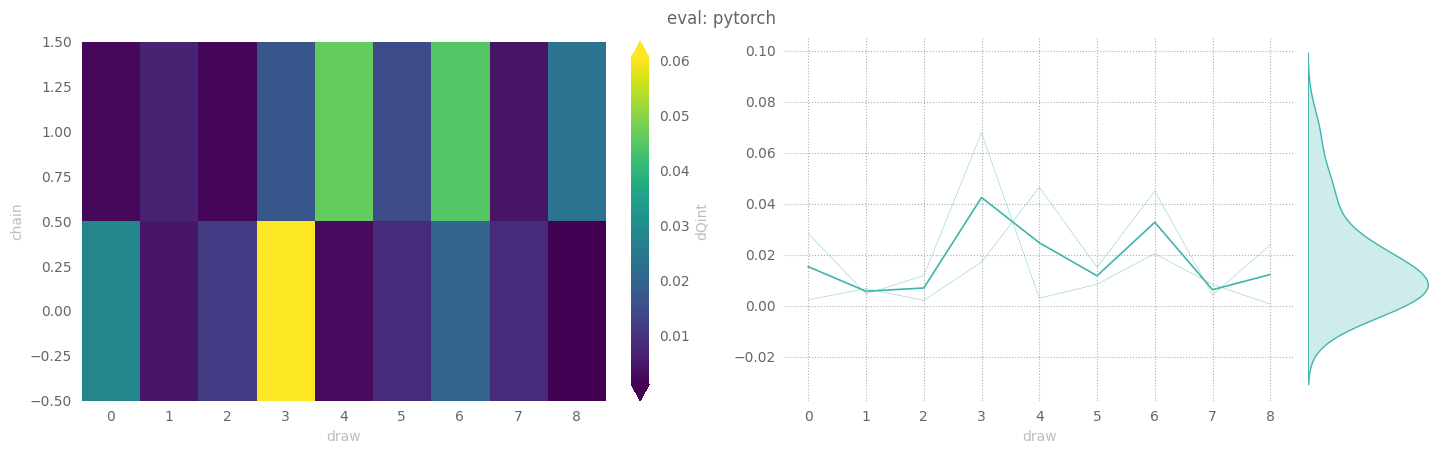

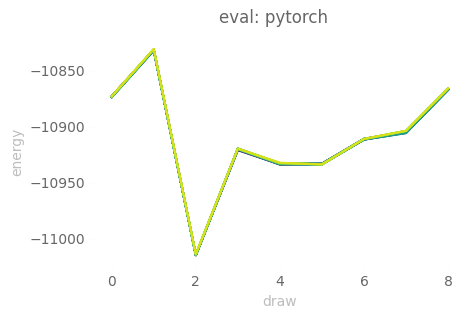

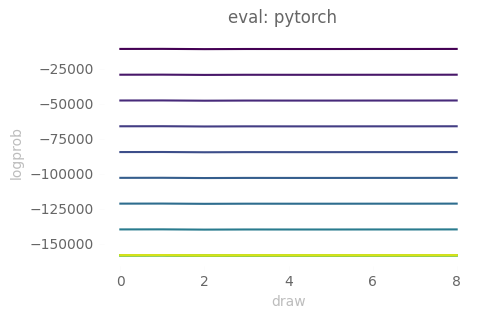

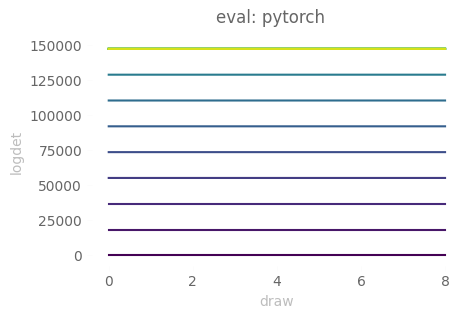

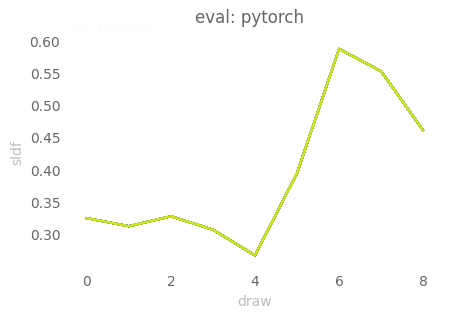

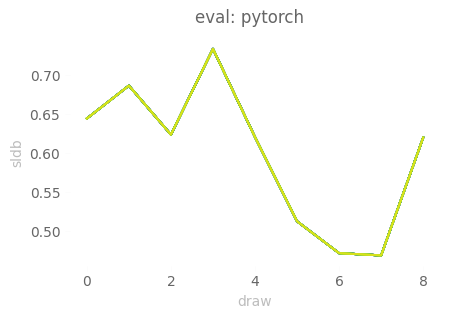

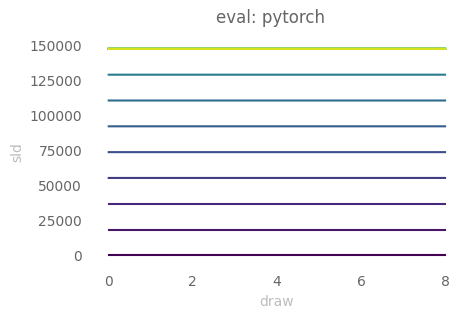

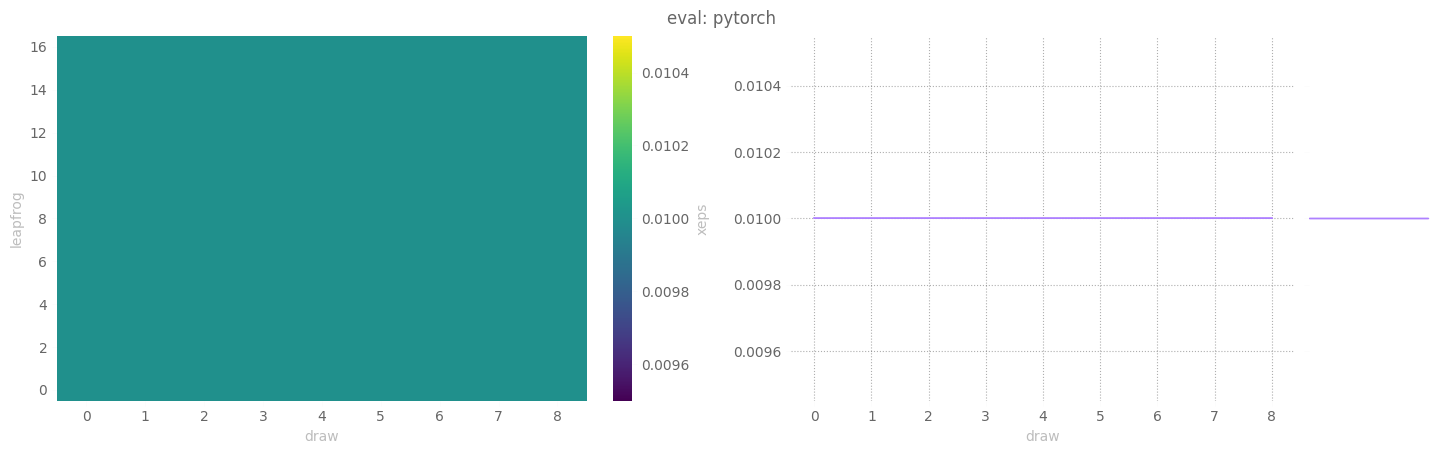

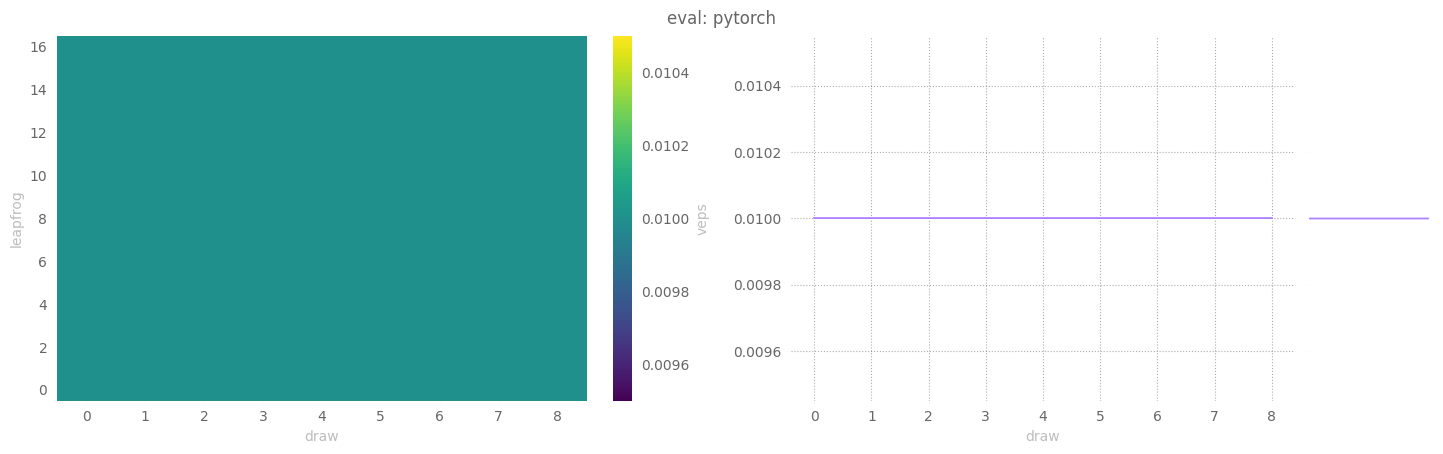

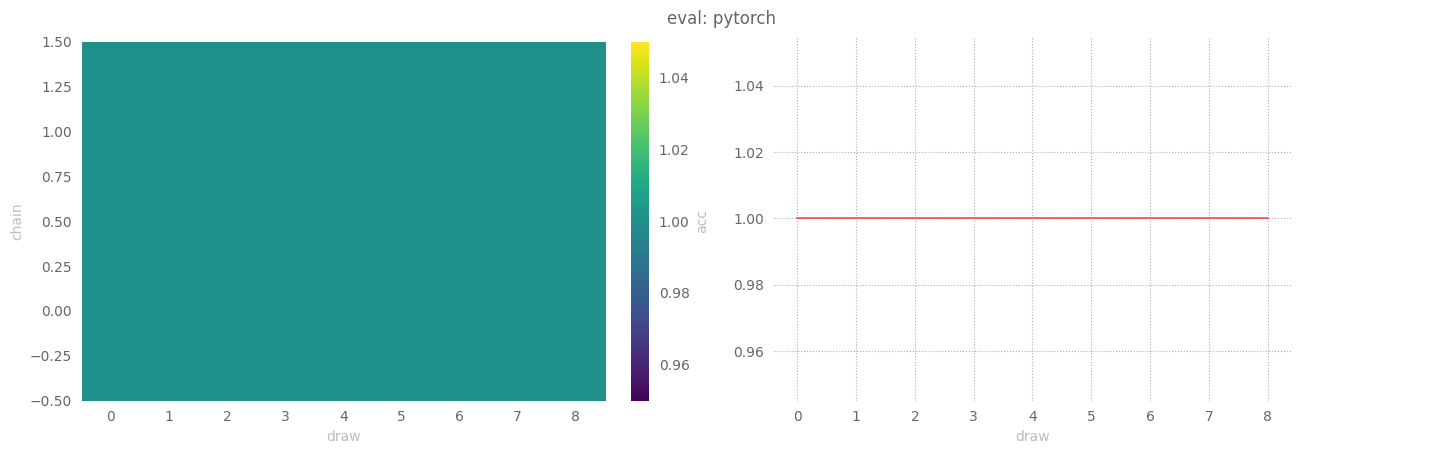

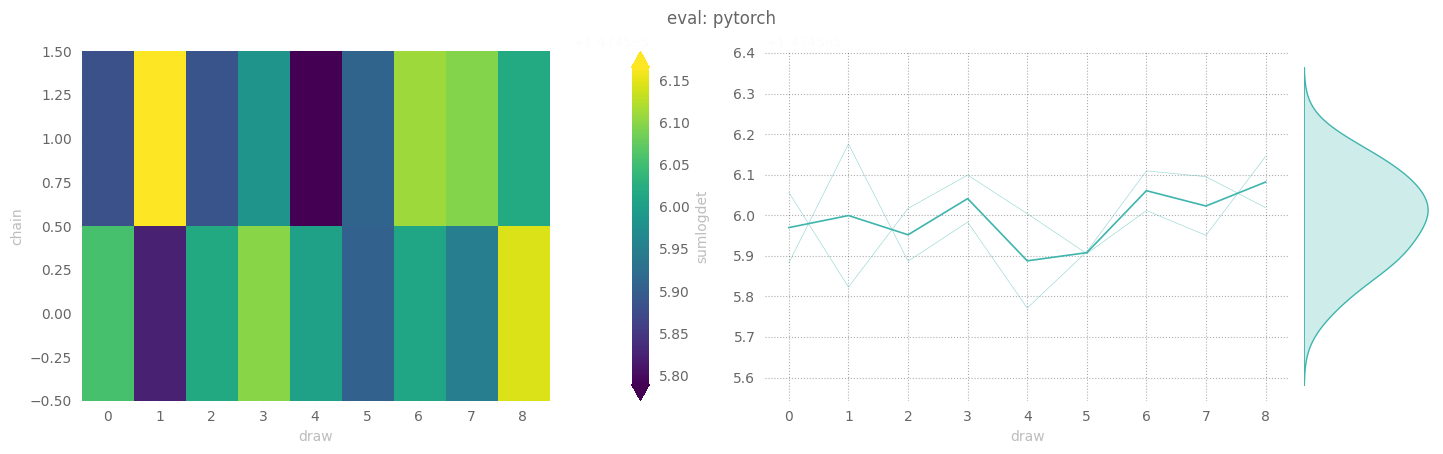

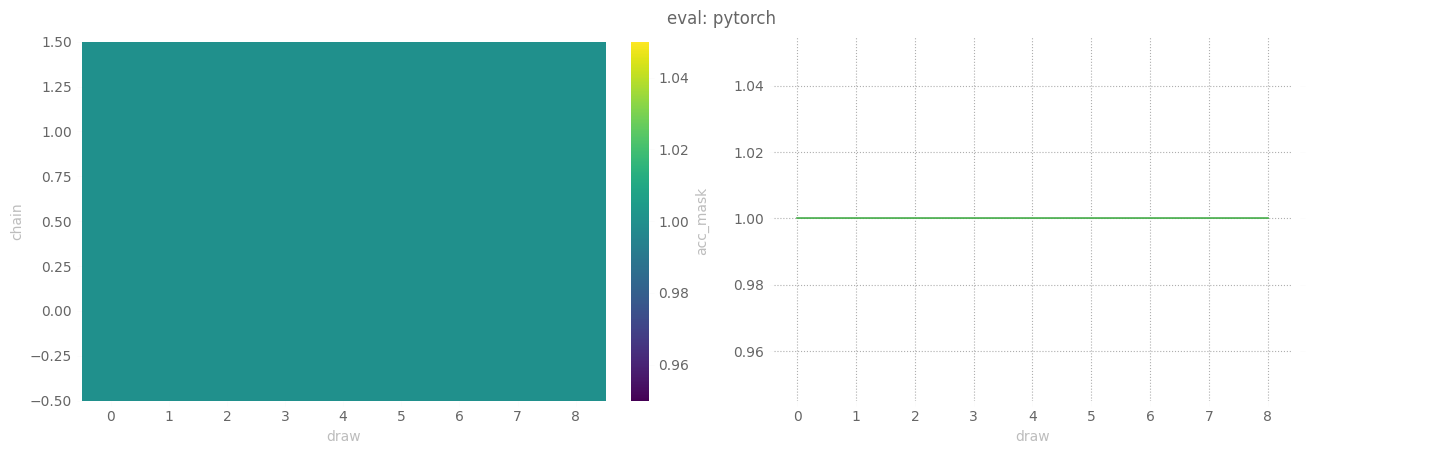

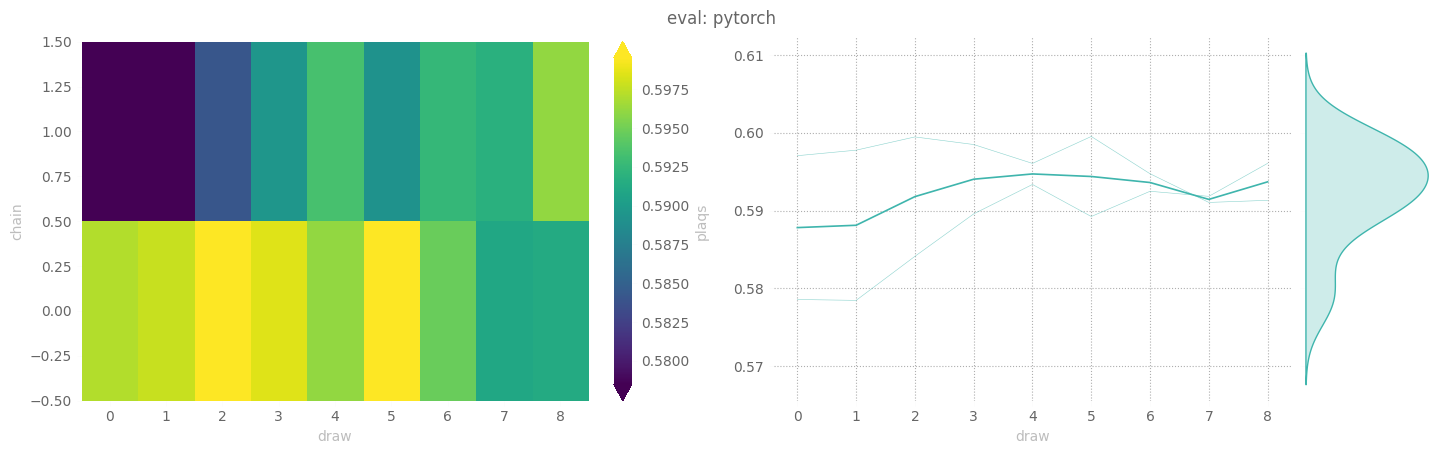

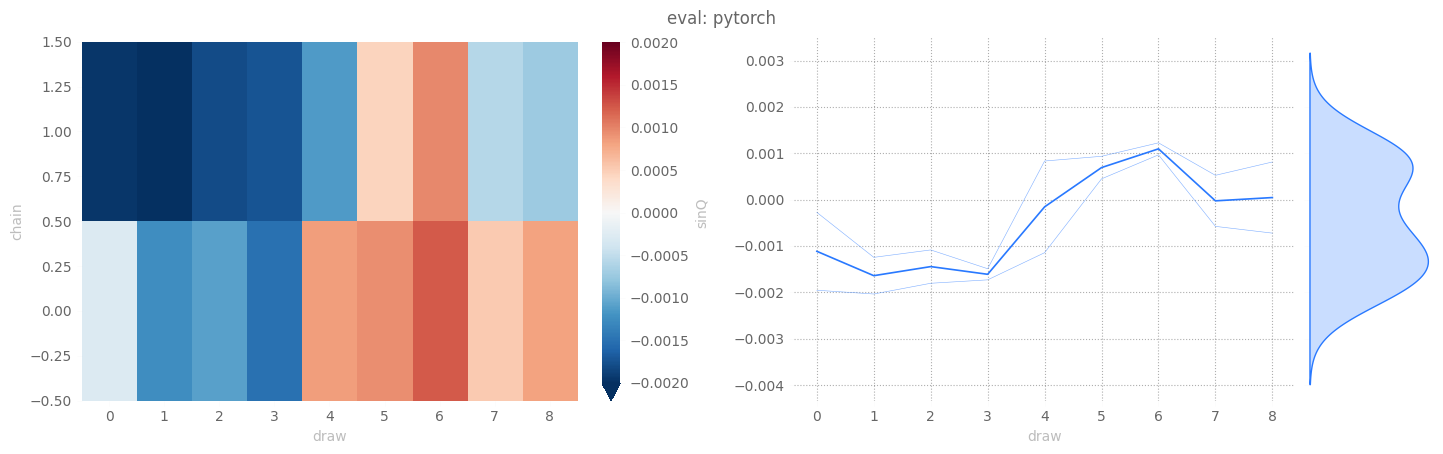

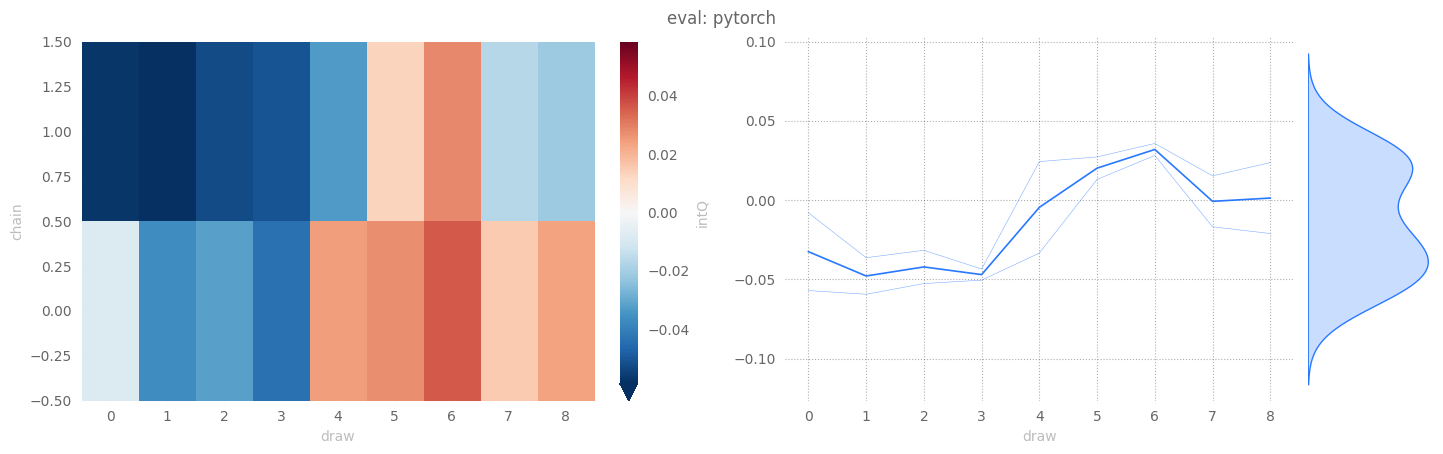

In [9]:
eval_out = ptExpSU3.evaluate(
    job_type='eval',
    beta=6.0,
    eval_steps=10,
    nprint=1,
)

## Generic HMC

[21:01:43] WARNING  x.shape (original): torch.Size([2, 4, 4, 4, 4, 8, 3, 3])

           INFO     eps=0.075                                                                                           
                    beta=6.0                                                                                            
                    nlog=1                                                                                              
                    table=<rich.table.Table object at 0x7f06b04d6910>                                                   
                    nprint=1                                                                                            
                    eval_steps=10                                                                                       
                    nleapfrog=16

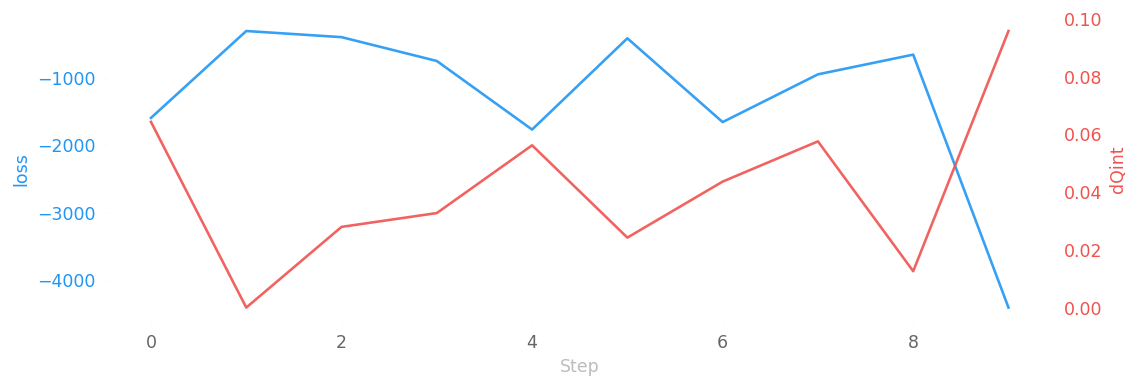

hmc:   0%|          | 0/10 [00:00<?, ?it/s]

[21:01:41] INFO     hstep=0   dt=0.2765 beta=6.0000 loss=-1595.8199 dQsin=0.0022 dQint=0.0643 energy=-10986.7014        
                    logprob=-10986.7014 logdet=0.0000 acc=0.6394 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.5946          
                    sinQ=0.0011 intQ=0.0324

           INFO     hstep=1   dt=0.2832 beta=6.0000 loss=-308.8383 dQsin=0.0000 dQint=0.0000 energy=-10896.7842         
                    logprob=-10896.7842 logdet=0.0000 acc=0.1668 sumlogdet=0.0000 acc_mask=0.0000 plaqs=0.5945          
                    sinQ=-0.0011 intQ=-0.0319

[21:01:42] INFO     hstep=2   dt=0.2816 beta=6.0000 loss=-399.7182 dQsin=0.0010 dQint=0.0280 energy=-10928.2983         
                    logprob=-10928.2983 logdet=0.0000 acc=0.5581 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.5945          
                    sinQ=-0.0011 intQ=-0.0319

           INFO     hstep=3   dt=0.2817 beta=6.0000 loss=-752.8123 dQsin=0.0011 dQint=0.0327 energy=-10905.8577         
                    logprob=-10905.8577 logdet=0.0000 acc=0.3171 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.5918          
                    sinQ=-0.0001 intQ=-0.0040

[21:01:43] INFO     hstep=4   dt=0.2820 beta=6.0000 loss=-1768.3996 dQsin=0.0019 dQint=0.0562 energy=-10929.9866        
                    logprob=-10929.9866 logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.5909          
                    sinQ=-0.0002 intQ=-0.0049

[21:01:44] INFO     hstep=5   dt=0.2849 beta=6.0000 loss=-416.8979 dQsin=0.0008 dQint=0.0242 energy=-10892.6561         
                    logprob=-10892.6561 logdet=0.0000 acc=0.2657 sumlogdet=0.0000 acc_mask=0.5000 plaqs=0.5950          
                    sinQ=-0.0001 intQ=-0.0037

           INFO     hstep=6   dt=0.2839 beta=6.0000 loss=-1657.7146 dQsin=0.0015 dQint=0.0436 energy=-10894.7638        
                    logprob=-10894.7638 logdet=0.0000 acc=0.7422 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.5936          
                    sinQ=-0.0010 intQ=-0.0279

[21:01:45] INFO     hstep=7   dt=0.2820 beta=6.0000 loss=-950.7159 dQsin=0.0020 dQint=0.0576 energy=-10825.9703         
                    logprob=-10825.9703 logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.5910          
                    sinQ=-0.0008 intQ=-0.0220

           INFO     hstep=8   dt=0.2828 beta=6.0000 loss=-658.6394 dQsin=0.0004 dQint=0.0126 energy=-10849.5365         
                    logprob=-10849.5365 logdet=0.0000 acc=0.3042 sumlogdet=0.0000 acc_mask=0.5000 plaqs=0.5916          
                    sinQ=0.0012 intQ=0.0356

[21:01:46] INFO     hstep=9   dt=0.2858 beta=6.0000 loss=-4404.7785 dQsin=0.0033 dQint=0.0958 energy=-10838.5193        
                    logprob=-10838.5193 logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.5888          
                    sinQ=0.0017 intQ=0.0482

[21:01:47] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/hmc/plots/ridgeplots/svgs/energy_ridgeplot.svg

[21:01:48] INFO     Ridgeplot for energy took 2.297s

[21:01:50] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/hmc/plots/ridgeplots/svgs/logprob_ridgeplot.svg

[21:01:51] INFO     Ridgeplot for logprob took 2.483s

[21:01:53] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/hmc/plots/ridgeplots/svgs/logdet_ridgeplot.svg

[21:01:54] INFO     Ridgeplot for logdet took 2.855s

[21:01:01] INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hm
                    c/notebooks/outputs/2023-01-26-212555/pytorch/hmc/data/hmc_data.h5

           INFO     Done saving and analyzing data.

           INFO     Creating summaries for WandB, Aim

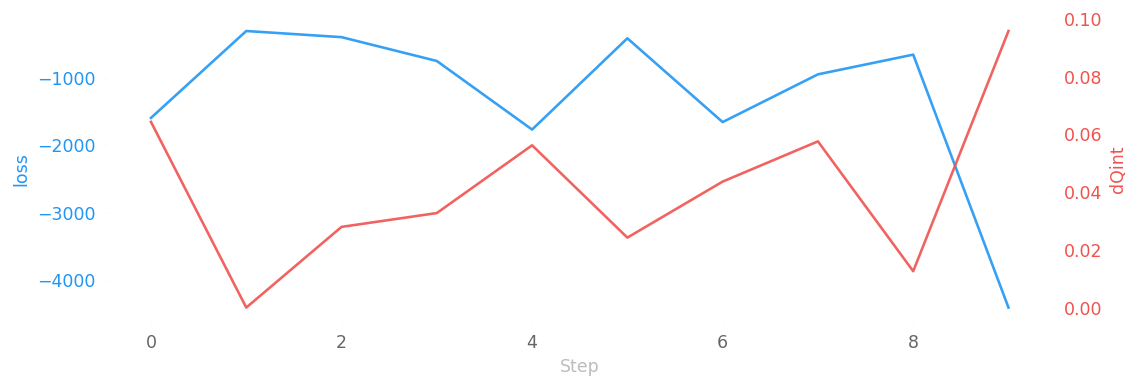

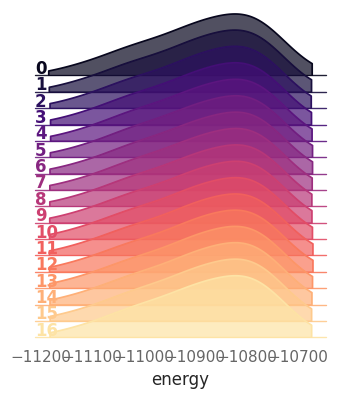

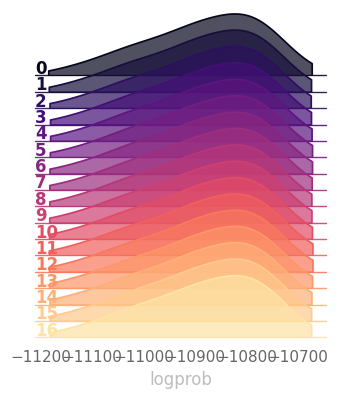

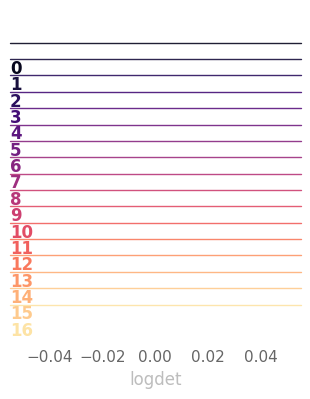

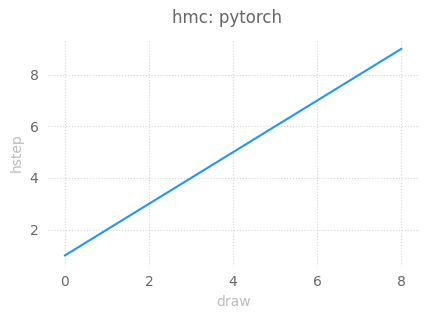

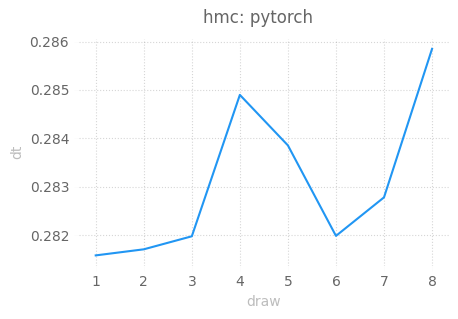

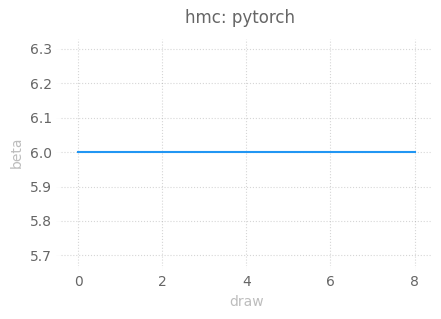

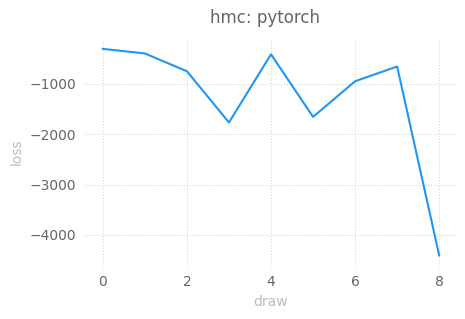

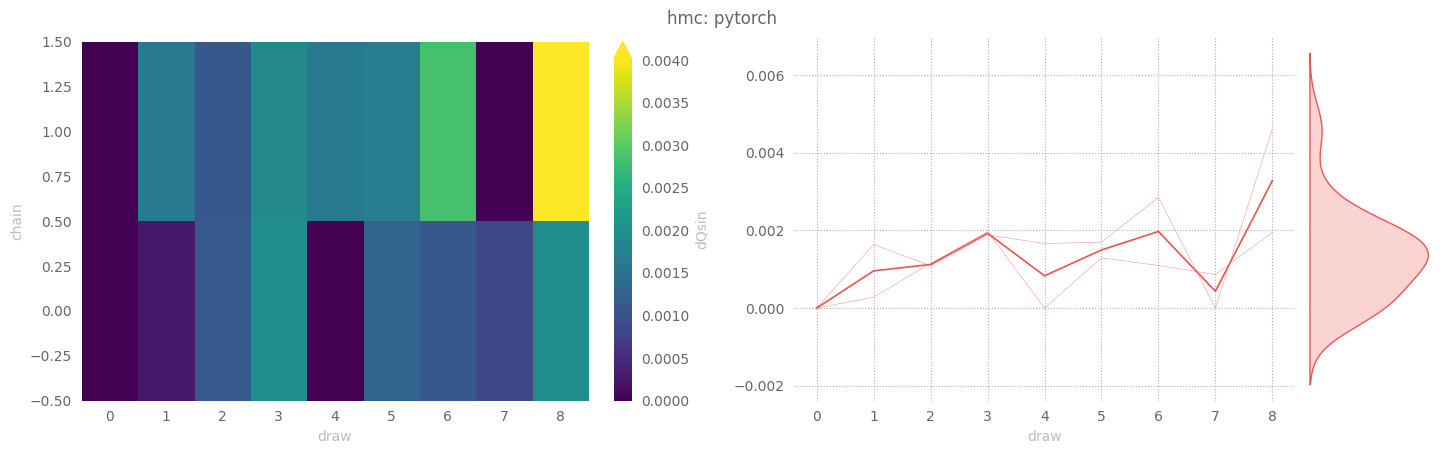

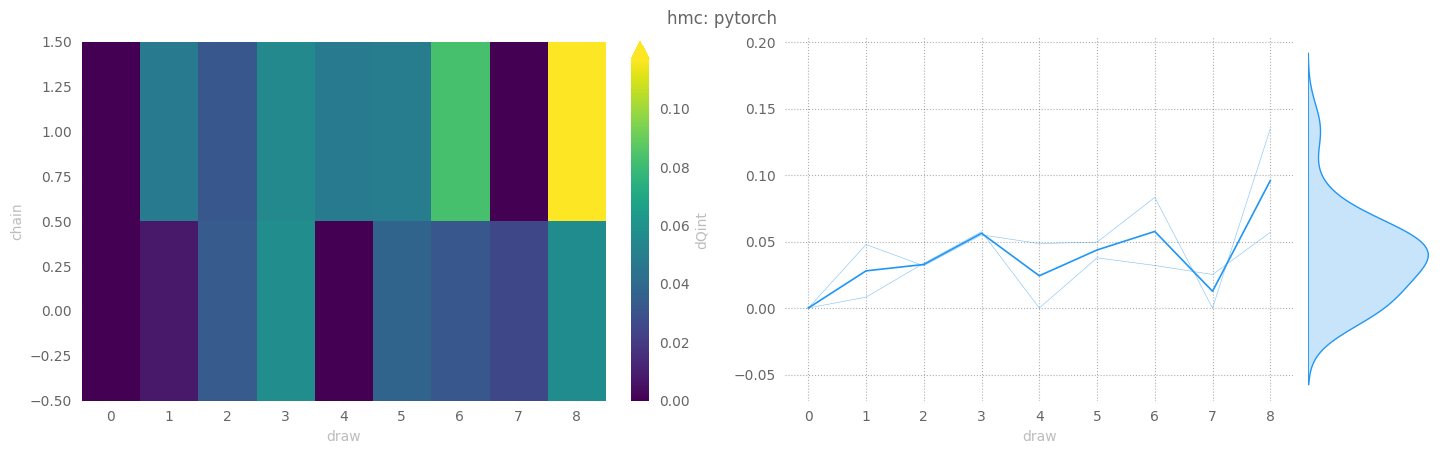

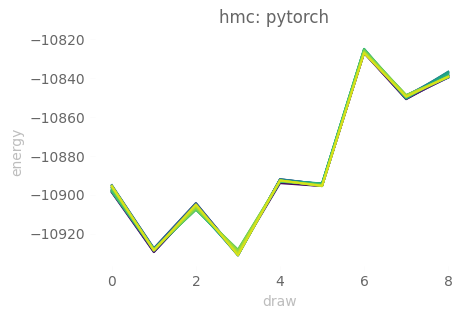

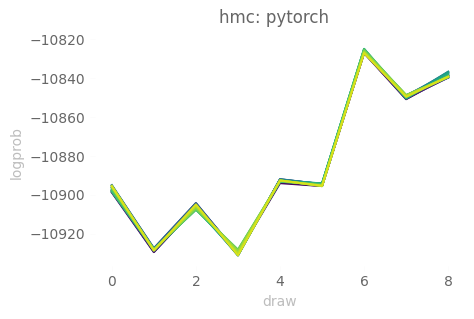

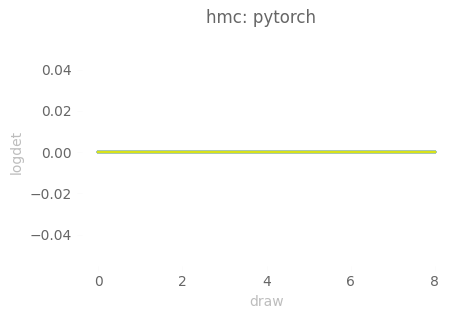

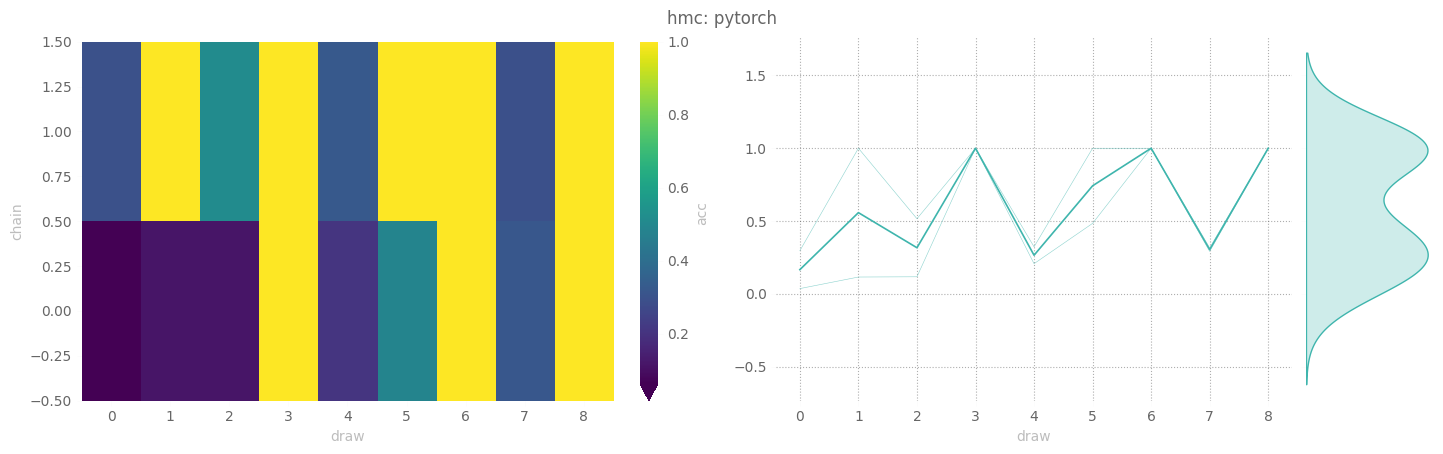

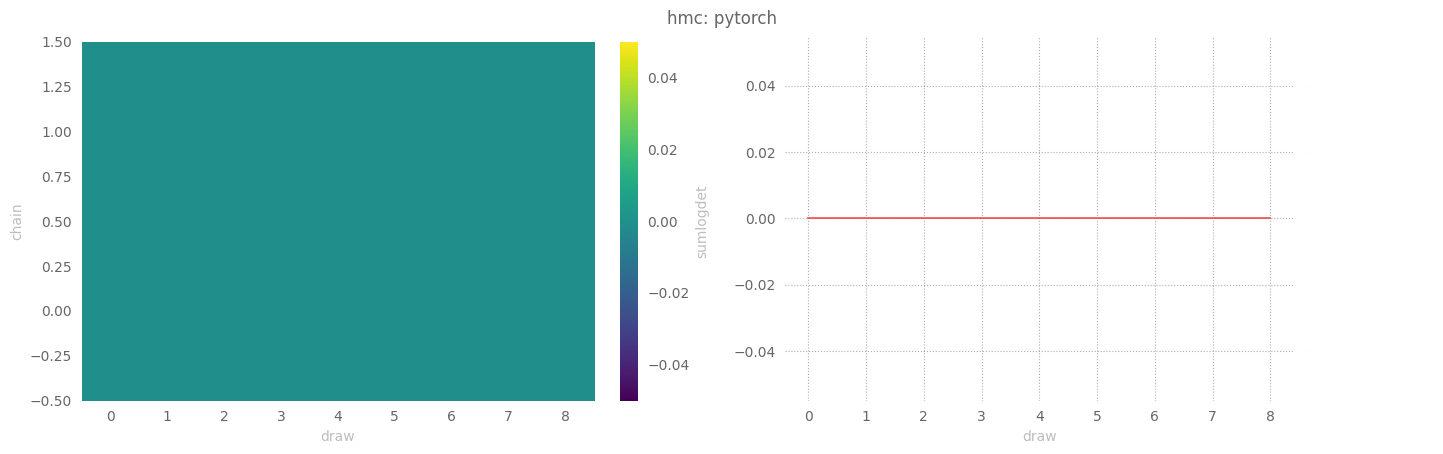

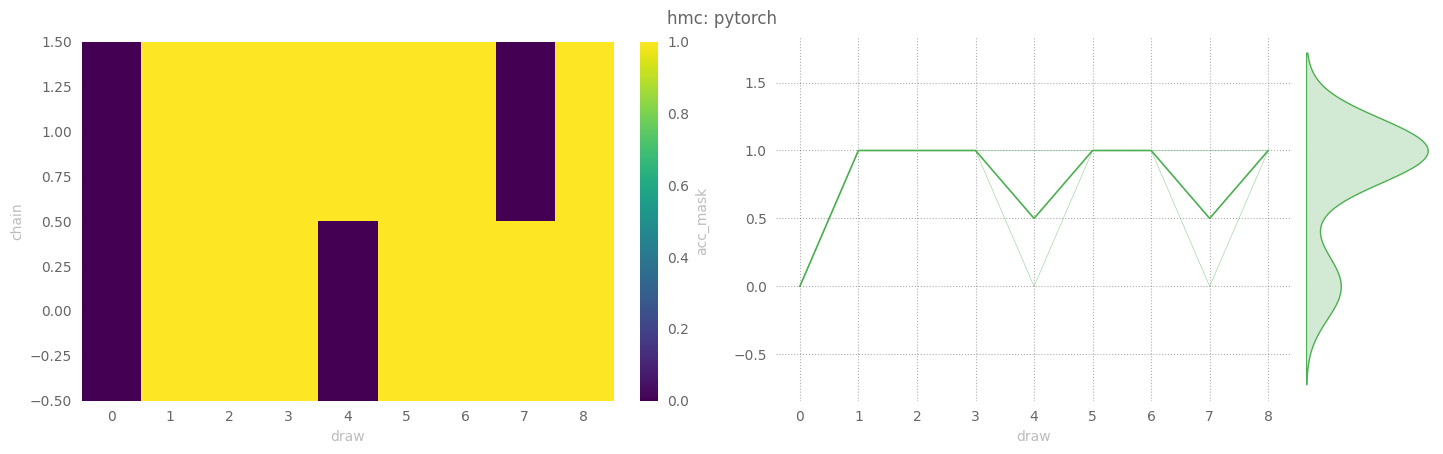

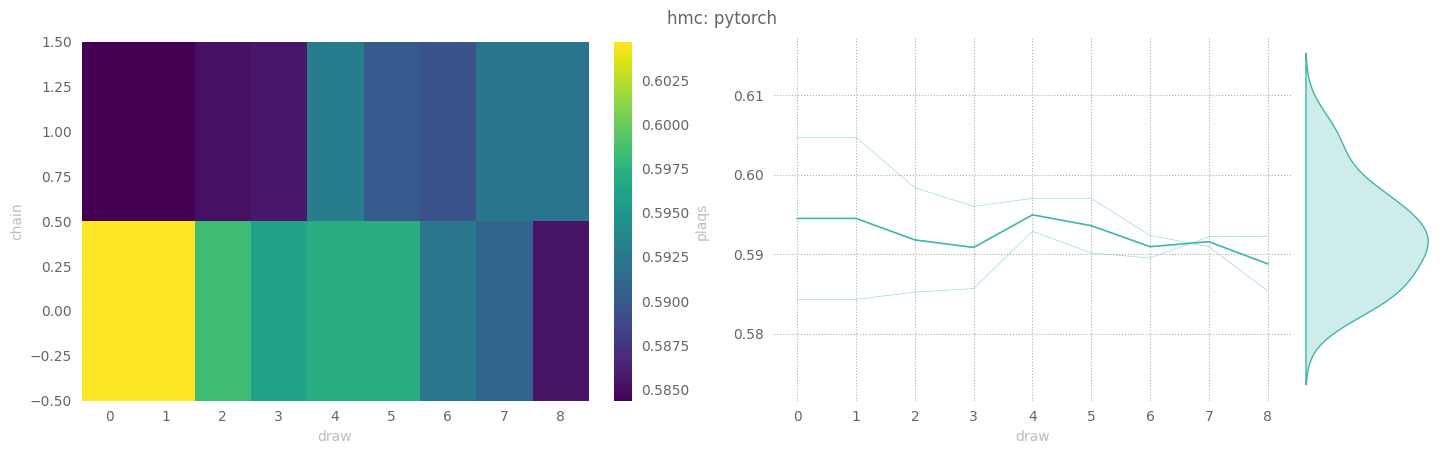

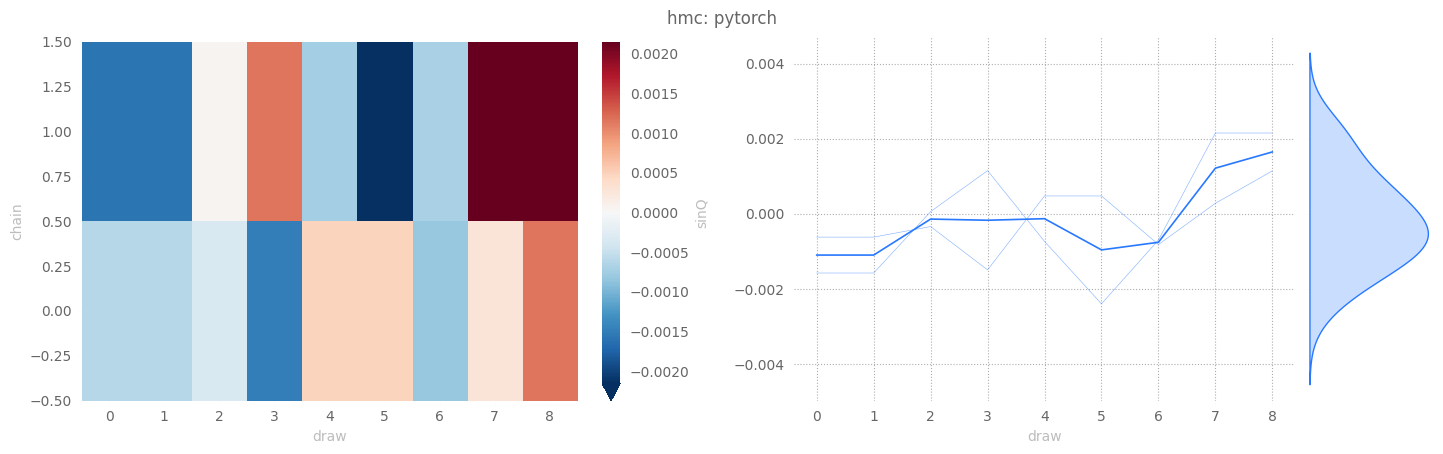

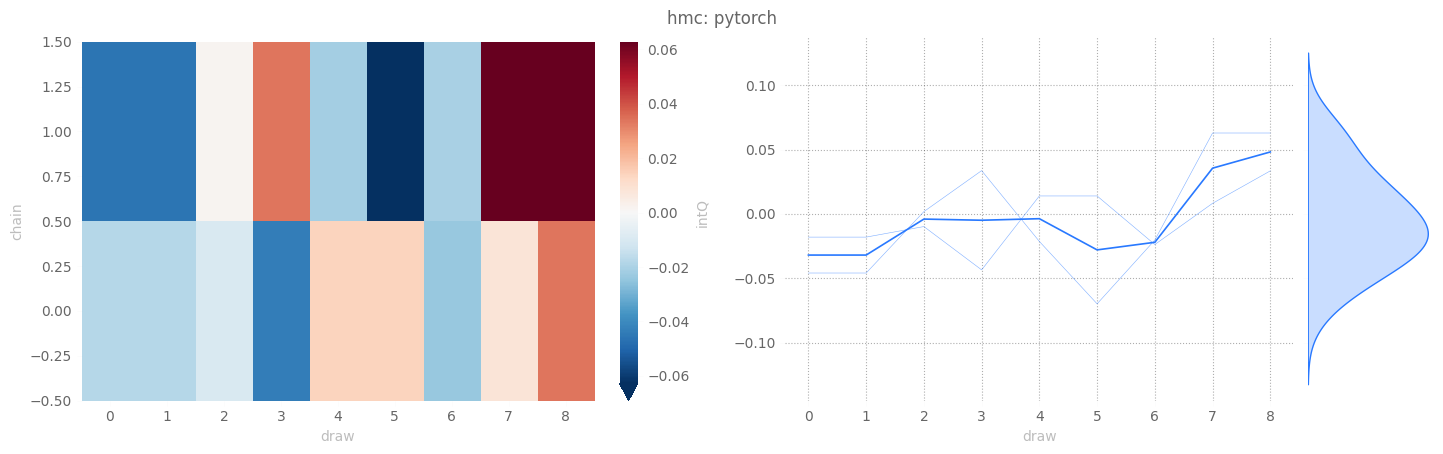

In [10]:
hmc_out = ptExpSU3.evaluate(
    job_type='hmc',
    beta=6.0,
    eval_steps=10,
    nprint=1,
    eps=0.075,
)